# Importations

In [1]:
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.io import output_notebook

#Prediction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import timeit
from sklearn.metrics import confusion_matrix

# Load Data

We start by loading our dataset and our dictionaries which are .csv

In [2]:
df = pd.read_csv("diabetic_data.csv",sep=',',index_col=0)
values=pd.read_csv("IDS_mapping.csv",sep=",")

In [3]:
# Creating a dictionary to interpret numbers
# Initialize a list to store subsets of data (dictionaries)
subsets = []

# Initialize an index to track the positions of division
division_index = []

# Iterate through the rows of the dataset
for i, row in enumerate(values.iterrows()):
    # Access the values of the row
    row_values = row[1].values

    # Check if the row is equal to ["Nan", "Nan"]
    if all(pd.isna(value) for value in row_values):
        # Add the current index as a division position
        division_index.append(i)

# Add the start and end index for the last subset
division_index = [0] + division_index + [len(values)]

# Split the dataset into subsets using the division positions
for start, end in zip(division_index[:-1], division_index[1:]):
    keys = values["admission_type_id"].iloc[start:end]
    values_subset = values["description"].iloc[start:end]
    subsets.append(dict(list(zip(keys, values_subset))))

# Run only once
Admission_type = subsets[0]
Discharge_dispo = subsets[1]
Discharge_dispo.pop("discharge_disposition_id")
Admission_source = subsets[2]
Admission_source.pop("admission_source_id")

print(Admission_type, "\n", Discharge_dispo, "\n", Admission_source)

{'1': 'Emergency', '2': 'Urgent', '3': 'Elective', '4': 'Newborn', '5': 'Not Available', '6': nan, '7': 'Trauma Center', '8': 'Not Mapped'} 
 {nan: nan, '1': 'Discharged to home', '2': 'Discharged/transferred to another short term hospital', '3': 'Discharged/transferred to SNF', '4': 'Discharged/transferred to ICF', '5': 'Discharged/transferred to another type of inpatient care institution', '6': 'Discharged/transferred to home with home health service', '7': 'Left AMA', '8': 'Discharged/transferred to home under care of Home IV provider', '9': 'Admitted as an inpatient to this hospital', '10': 'Neonate discharged to another hospital for neonatal aftercare', '11': 'Expired', '12': 'Still patient or expected to return for outpatient services', '13': 'Hospice / home', '14': 'Hospice / medical facility', '15': 'Discharged/transferred within this institution to Medicare approved swing bed', '16': 'Discharged/transferred/referred another institution for outpatient services', '17': 'Discharg

In [4]:
Dico={}
Dico["Admission_type"]=Admission_type
Dico["Discharge_dispo"]=Discharge_dispo
Dico["Admission_source"]=Admission_source
Dico

{'Admission_type': {'1': 'Emergency',
  '2': 'Urgent',
  '3': 'Elective',
  '4': 'Newborn',
  '5': 'Not Available',
  '6': nan,
  '7': 'Trauma Center',
  '8': 'Not Mapped'},
 'Discharge_dispo': {nan: nan,
  '1': 'Discharged to home',
  '2': 'Discharged/transferred to another short term hospital',
  '3': 'Discharged/transferred to SNF',
  '4': 'Discharged/transferred to ICF',
  '5': 'Discharged/transferred to another type of inpatient care institution',
  '6': 'Discharged/transferred to home with home health service',
  '7': 'Left AMA',
  '8': 'Discharged/transferred to home under care of Home IV provider',
  '9': 'Admitted as an inpatient to this hospital',
  '10': 'Neonate discharged to another hospital for neonatal aftercare',
  '11': 'Expired',
  '12': 'Still patient or expected to return for outpatient services',
  '13': 'Hospice / home',
  '14': 'Hospice / medical facility',
  '15': 'Discharged/transferred within this institution to Medicare approved swing bed',
  '16': 'Discharge

# First Data Visualisation

Let's have a first look at what our dataset looks like:

In [5]:
df.head().T

encounter_id                               2278392    149190   \
patient_nbr                                8222157   55629189   
race                                     Caucasian  Caucasian   
gender                                      Female     Female   
age                                         [0-10)    [10-20)   
weight                                           ?          ?   
admission_type_id                                6          1   
discharge_disposition_id                        25          1   
admission_source_id                              1          7   
time_in_hospital                                 1          3   
payer_code                                       ?          ?   
medical_specialty         Pediatrics-Endocrinology          ?   
num_lab_procedures                              41         59   
num_procedures                                   0          0   
num_medications                                  1         18   
number_outpatient                                0          0   
number_emergency                                 0          0   
number_inpatient                                 0          0   
diag_1                                      250.83        276   
diag_2                                           ?     250.01   
diag_3                                           ?        255   
number_diagnoses                                 1          9   
max_glu_serum                                 None       None   
A1Cresult                                     None       None   
metformin                                       No         No   
repaglinide                                     No         No   
nateglinide                                     No         No   
chlorpropamide                                  No         No   
glimepiride                                     No         No   
acetohexamide                                   No         No   
glipizide                                       No         No   
glyburide                                       No         No   
tolbutamide                                     No         No   
pioglitazone                                    No         No   
rosiglitazone                                   No         No   
acarbose                                        No         No   
miglitol                                        No         No   
troglitazone                                    No         No   
tolazamide                                      No         No   
examide                                         No         No   
citoglipton                                     No         No   
insulin                                         No         Up   
glyburide-metformin                             No         No   
glipizide-metformin                             No         No   
glimepiride-pioglitazone                        No         No   
metformin-rosiglitazone                         No         No   
metformin-pioglitazone                          No         No   
change                                          No         Ch   
diabetesMed                                     No        Yes   
readmitted                                      NO        >30   

encounter_id                      64410      500364     16680    
patient_nbr                      86047875   82442376   42519267  
race                      AfricanAmerican  Caucasian  Caucasian  
gender                             Female       Male       Male  
age                               [20-30)    [30-40)    [40-50)  
weight                                  ?          ?          ?  
admission_type_id                       1          1          1  
discharge_disposition_id                1          1          1  
admission_source_id                     7          7          7  
time_in_hospital                        2          2          1  
payer_code                              ?          ?          ?  
medical_specialty      

In [6]:
df.dtypes

patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide       

We have to types of values: integers and object (categories). Some integers are id corresponding to the dictionary we uploaded earlier.

We can see for each colonne what are the possible values and how many time they are reapeted:

In [7]:
for column in df.columns:
    print(df[column].value_counts())

88785891     40
43140906     28
1660293      23
88227540     23
23199021     23
             ..
11005362      1
98252496      1
1019673       1
13396320      1
175429310     1
Name: patient_nbr, Length: 71518, dtype: int64
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64
Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64
1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4 

# Missing values
In this dataset missing values are indicated by a ? instead on None. And by Unknown/Invalid for the gender column.

In [8]:
df.isna().sum()

patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitaz

There is no NAN in the dataset let's replace each unknwon value by Nan to simplify the treatment

In [9]:
df.replace(['?','Unknown/Invalid'], pd.NA, inplace=True)

In [10]:
df.isna().sum()/len(df)*100

patient_nbr                  0.000000
race                         2.233555
gender                       0.002948
age                          0.000000
weight                      96.858479
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.557416
medical_specialty           49.082208
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.020636
diag_2                       0.351787
diag_3                       1.398306
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide                  0.000000
chlorpropami

The columns weight, medical speciality and payer code have to many missing values to be kept in the dataset.

In [11]:
df.drop(['weight','payer_code','medical_specialty'], axis=1, inplace=True)

The rest of the missing values only conscerne a few rows and cutting them out of the dataset will not have a big impact on the result (<4% all cumulated)

In [12]:
df.dropna(inplace=True)

We also saw by looking at the different columns values that some medicine are never given. In consequences they give us no useful information about the individuals and so we do not need them.

In [13]:
same_values_columns=df.columns[df.nunique()==1]
df = df.drop(columns=same_values_columns)
print("Drop of ",same_values_columns)

Drop of  Index(['examide', 'citoglipton', 'metformin-rosiglitazone'], dtype='object')


In [14]:
df.columns

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

In [15]:
df_medicines=['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone']

We are searching for the medicine rarely taken by patients (minus than 95%).

In [16]:
rare_medicines=[]
i=0
for medicin in df_medicines:
    count_no = (df[medicin] == 'No').sum()
    if count_no/df.shape[0]>0.95:
        i+=1
        print(f"{medicin}: {count_no}")
        rare_medicines.append(medicin)
print(i)

repaglinide: 96529
nateglinide: 97361
chlorpropamide: 97969
acetohexamide: 98051
tolbutamide: 98030
acarbose: 97753
miglitol: 98015
troglitazone: 98049
tolazamide: 98015
glyburide-metformin: 97383
glipizide-metformin: 98039
glimepiride-pioglitazone: 98051
metformin-pioglitazone: 98051
13


We have a lot of columns and this ones conserne not many patients. So we can regroup all of them in one columns

In [17]:
# Create a new column indicating whether all columns in rare_medicines are equal to 'No'
df['rare_medicine_taken'] = (df[rare_medicines] == 'No').all(axis=1)
df.drop(df[rare_medicines],axis=1,inplace=True)

In [18]:
df.columns

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted',
       'rare_medicine_taken'],
      dtype='object')

We are interested in the correlations between various parameters and the likelihood of a patient returning to the hospital.

However, only a quarter return frequently, considering that the average is 2.8

# Duplicates

In [19]:
df.duplicated().sum()

0

In [20]:
print(df.shape)
df1=df.drop_duplicates()
print(df.shape,df1.shape)

(98052, 31)
(98052, 31) (98052, 31)


There is no duplicates in the datafram

# Reincoding

In this part we are using the dictionnary to reincode the data set with the right variables. Then when we will plot some graph it will be easier to understand there meaning.

In [21]:
df['admission_type'] = df['admission_type_id'].astype(str).map(Admission_type)
df = df.drop('admission_type_id',axis=1)
df['discharge_disposition'] = df['discharge_disposition_id'].astype(str).map(Discharge_dispo)
df = df.drop('discharge_disposition_id',axis=1)
df['admission_source'] = df['admission_source_id'].astype(str).map(Admission_source)
df = df.drop('admission_source_id',axis=1)

We where wondering the meaning of the diagnostic values. Each tag correspond to a specific diagnostic but in the dataset there was more than 700 different diagnostics which is to many to treat correctly.

The diagnostics digit correspond to the ICD diagnosist. To limit the number of categories (more than 700) we can regroup them in only 19 disease types: https://icd.codes/icd9cm 

In [22]:
# Définir le dictionnaire associant les codes de plage aux descriptions
dictionnaire_codes = {
    tuple(range(1, 140)): "Infectious And Parasitic Diseases",
    tuple(range(140, 240)): "Neoplasms",
    tuple(range(240, 280)): "Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",
    tuple(range(280, 290)): "Diseases Of The Blood And Blood-Forming Organs",
    tuple(range(290, 320)): "Mental Disorders",
    tuple(range(320, 390)): "Diseases Of The Nervous System And Sense Organs",
    tuple(range(390, 460)): "Diseases Of The Circulatory System",
    tuple(range(460, 520)): "Diseases Of The Respiratory System",
    tuple(range(520, 580)): "Diseases Of The Digestive System",
    tuple(range(580, 630)): "Diseases Of The Genitourinary System",
    tuple(range(630, 680)): "Complications Of Pregnancy, Childbirth, And The Puerperium",
    tuple(range(680, 710)): "Diseases Of The Skin And Subcutaneous Tissue",
    tuple(range(710, 740)): "Diseases Of The Musculoskeletal System And Connective Tissue",
    tuple(range(740, 760)): "Congenital Anomalies",
    tuple(range(760, 780)): "Certain Conditions Originating In The Perinatal Period",
    tuple(range(780, 800)): "Symptoms, Signs, And Ill-Defined Conditions",
    tuple(range(800, 1000)): "Injury And Poisoning",
    'V': "Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services",
    'E': "Supplementary Classification Of External Causes Of Injury And Poisoning"
}

def trouver_description_pour_valeur(valeur):
    valeur_str = str(valeur)

    # Vérifier si la valeur commence par "V" ou "E"
    if valeur_str.startswith("V") or valeur_str.startswith("E"):
        return dictionnaire_codes.get(valeur_str[0])
    
    # Essayer d'arrondir la valeur et convertir en entier
    valeur_arrondie_entiere = int(round(float(valeur)))

    # Recherche dans les plages de codes
    for plage, description in dictionnaire_codes.items():
        if valeur_arrondie_entiere in plage:
            return description
    
    return "Code non trouvé"


In [23]:
for colonne in ['diag_1', 'diag_2', 'diag_3']:
    df[colonne] = df[colonne].apply(trouver_description_pour_valeur)

In [24]:
df.isna().sum()

patient_nbr                 0
race                        0
gender                      0
age                         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
glimepiride                 0
glipizide                   0
glyburide                   0
pioglitazone                0
rosiglitazone               0
insulin                     0
change                      0
diabetesMed                 0
readmitted                  0
rare_medicine_taken         0
admission_type           5135
discharge_disposition    3624
admission_source         6602
dtype: int64

In the dictionnaries some numbers correspond to null values. So we end up with some Nan values. As there was already a Not Available category for admission type and source we decided to add the Nan values to this category.

In [25]:
df['admission_type'].fillna('Not Available', inplace=True)
df['admission_source'].fillna('Not Available', inplace=True)
df.dropna(inplace=True)

# Value to int

In this section we are trandforming age section into integers to treat them while keeping the connection between the values (40/50 is closer to 50/60 than 10/20).
We transformed our target variable readmitted into binary integer 1 if the patient is readmitted 0 if not.
FInally we transformed variables with only to categories into binary integers.

In [26]:
unique_values = sorted(df['age'].unique())
mapping = {value: index for index, value in enumerate(unique_values)}
df['age'] = df['age'].map(mapping).astype(int)
df['readmitted'] = df['readmitted'].replace(['<30','>30'], 1).replace('NO', 0)
df['gender'] = df['gender'].replace('Female', 0).replace('Male', 1)
df['change'] = df['change'].replace('No', 0).replace('Ch', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0).replace('Yes', 1)
df['rare_medicine_taken'] = df['rare_medicine_taken'].replace(False, 0).replace(True, 1)

In [27]:
df.T

encounter_id                                                   149190     \
patient_nbr                                                     55629189   
race                                                           Caucasian   
gender                                                                 0   
age                                                                    1   
time_in_hospital                                                       3   
num_lab_procedures                                                    59   
num_procedures                                                         0   
num_medications                                                       18   
number_outpatient                                                      0   
number_emergency                                                       0   
number_inpatient                                                       0   
diag_1                 Endocrine, Nutritional And Metabolic Diseases,...   
diag_2                 Endocrine, Nutritional And Metabolic Diseases,...   
diag_3                 Endocrine, Nutritional And Metabolic Diseases,...   
number_diagnoses                                                       9   
max_glu_serum                                                       None   
A1Cresult                                                           None   
metformin                                                             No   
glimepiride                                                           No   
glipizide                                                             No   
glyburide                                                             No   
pioglitazone                                                          No   
rosiglitazone                                                         No   
insulin                                                               Up   
change                                                                 1   
diabetesMed                                                            1   
readmitted                                                             1   
rare_medicine_taken                                                    1   
admission_type                                                 Emergency   
discharge_disposition                                 Discharged to home   
admission_source                                          Emergency Room   

encounter_id                                                   64410      \
patient_nbr                                                     86047875   
race                                                     AfricanAmerican   
gender                                                                 0   
age                                                                    2   
time_in_hospital                                                       2   
num_lab_procedures                                                    11   
num_procedures                                                         5   
num_medications                                                       13   
number_outpatient                                                      2   
number_emergency                                                       0   
number_inpatient                                                       1   
diag_1                 Complications Of Pregnancy, Childbirth, And Th...   
diag_2                 Endocrine, Nutritional And Metabolic Diseases,...   
diag_3                 Supplementary Classification Of Factors Influe...   
number_diagnoses                                                       6   
max_glu_serum                                                       None   
A1Cresult                                                           None   
metformin                                                             No   
glimepiride                                                           No   
glipizide                                      

# Encoding

In this dataset we are dealing with a lot of discret variables (cat) which we need to encode. We try to use the one hot encoding to avoid creating false correlations between values. 
Dealing with a lot of columns and values we where unsure this method would be effective so we also try a different type of encoding: target encoding

In [28]:
#target encoding
def encoding(data):
    for column in data.columns:
        if data[column].dtype != 'int64' and data[column].dtype != 'float' and column!='readmitted' and column!='patient_nbr' and column!='age':
            if len(data[column].unique()) != 2:
                target_mean = data.groupby(column)['readmitted'].mean()
                data[column] = data[column].map(target_mean)
    return data

In [29]:
def encoding_onehot(data):
    for column in data.columns:
        if data[column].dtype == 'object' and column not in ['readmitted', 'patient_nbr', 'age']:
            one_hot_encoded = pd.get_dummies(data[column], prefix=column, drop_first=True)
            data = pd.concat([data, one_hot_encoded], axis=1)
            data = data.drop(column, axis=1)
    return data


In [30]:
df2=df.copy()

In [31]:
df2=encoding_onehot(df2)

In [32]:
df2

patient_nbr  gender  age  time_in_hospital  num_lab_procedures  \
encounter_id                                                                   
149190           55629189       0    1                 3                  59   
64410            86047875       0    2                 2                  11   
500364           82442376       1    3                 2                  44   
16680            42519267       1    4                 1                  51   
35754            82637451       1    5                 3                  31   
...                   ...     ...  ...               ...                 ...   
443847548       100162476       1    7                 3                  51   
443847782        74694222       0    8                 5                  33   
443854148        41088789       1    7                 1                  53   
443857166        31693671       0    8                10                  45   
443867222       175429310       1    7                 6                  13   

              num_procedures  num_medications  number_outpatient  \
encounter_id                                                       
149190                     0               18                  0   
64410                      5               13                  2   
500364                     1               16                  0   
16680                      0                8                  0   
35754                      6               16                  0   
...                      ...              ...                ...   
443847548                  0               16                  0   
443847782                  3               18                  0   
443854148                  0                9                  1   
443857166                  2               21                  0   
443867222                  3                3                  0   

              number_emergency  number_inpatient  ...  \
encounter_id                                      ...   
149190                       0                 0  ...   
64410                        0                 1  ...   
500364                       0                 0  ...   
16680                        0                 0  ...   
35754                        0                 0  ...   
...                        ...               ...  ...   
443847548                    0                 0  ...   
443847782                    0                 1  ...   
443854148                    0                 0  ...   
443857166                    0                 1  ...   
443867222                    0                 0  ...   

              admission_source_ Transfer from Ambulatory Surgery Center  \
encounter_id                                                              
149190                                                        0           
64410                                                         0           
500364                                                        0           
16680                                                         0           
35754                                                         0           
...                                                         ...           
443847548                                                     0           
443847782                                                     0           
443854148                                                     0           
443857166                                                     0           
443867222                                                     0           

              admission_source_ Transfer from a Skilled Nursing Facility (SNF)  \
encounter_id                                                                     
149190                                                        0                  
64410                                                         0                  
500364                                    

# Visualisation

## Target distribution

We can start by visualising the distribution of our target value: readmitted

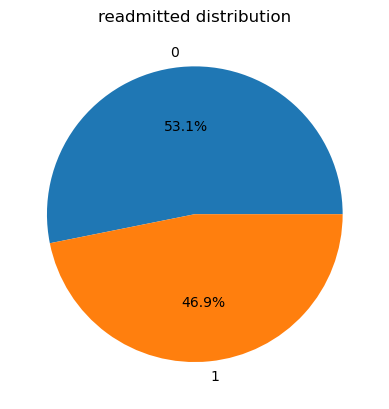

In [33]:
counts = df['readmitted'].value_counts()
plt.pie(counts,labels=counts.index,autopct='%1.1f%%')
plt.title('readmitted distribution')
plt.show()

We can see that the proportion of patient readmitted is slily under 50%. We can say that the target value well-balanced.

## Matrix Correlation


It would be interesting to encode certain columns and observe the correlations between those and the numeric columns we already have.

We created two functions for encoding the first one is target encoding and the second one is one hot encoding. Both allow us to handle discret values of the dataset.

In [34]:
df1=encoding(df.copy())

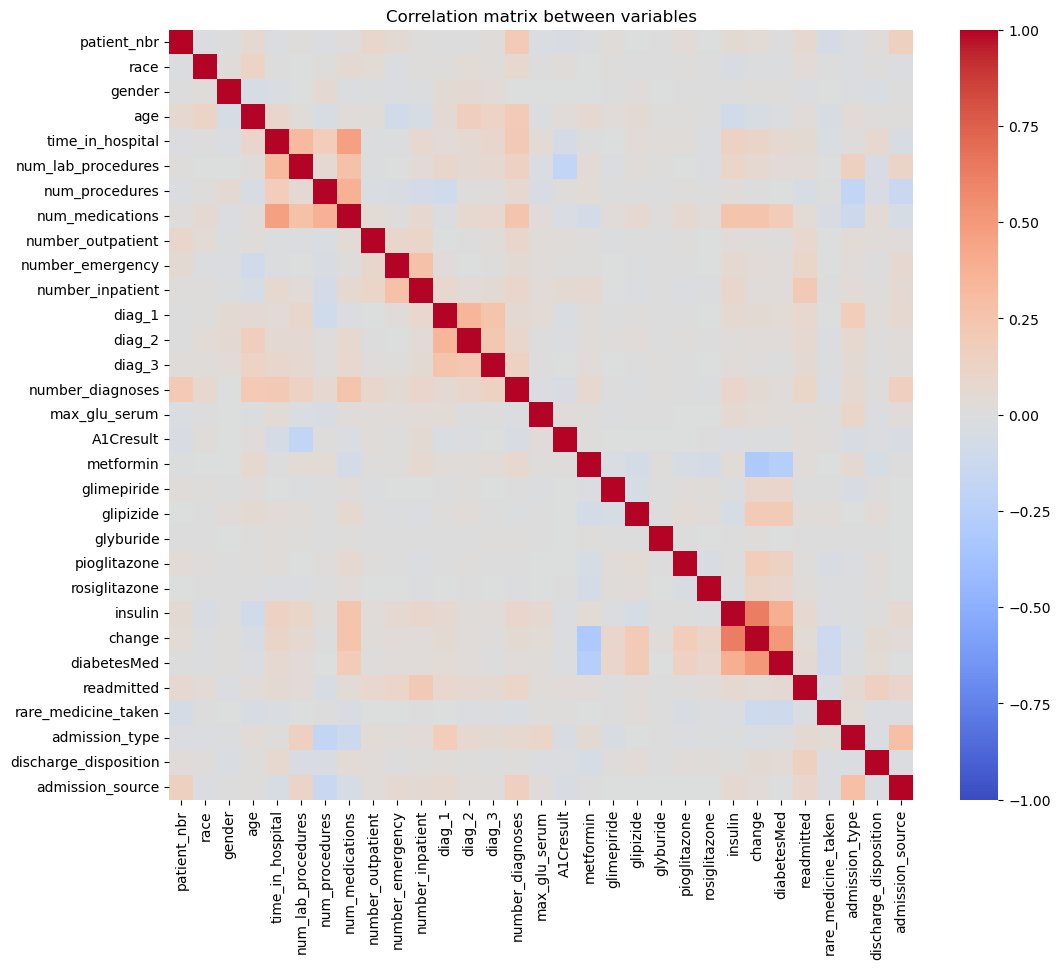

In [35]:
# Calcul of the correlation matrix
correlation_matrix = df1.corr()

# figure parameters
plt.figure(figsize=(12, 10))

# Creation of correlation map
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation matrix between variables')
plt.show()

This matrix is a little hard to read we are going to focus on some variables

In [36]:
colonnes_selected=['race','gender','age','admission_type','discharge_disposition','admission_source','time_in_hospital','num_procedures', 'number_diagnoses', 'max_glu_serum', 'A1Cresult','insulin','change', 'diabetesMed', 'readmitted']

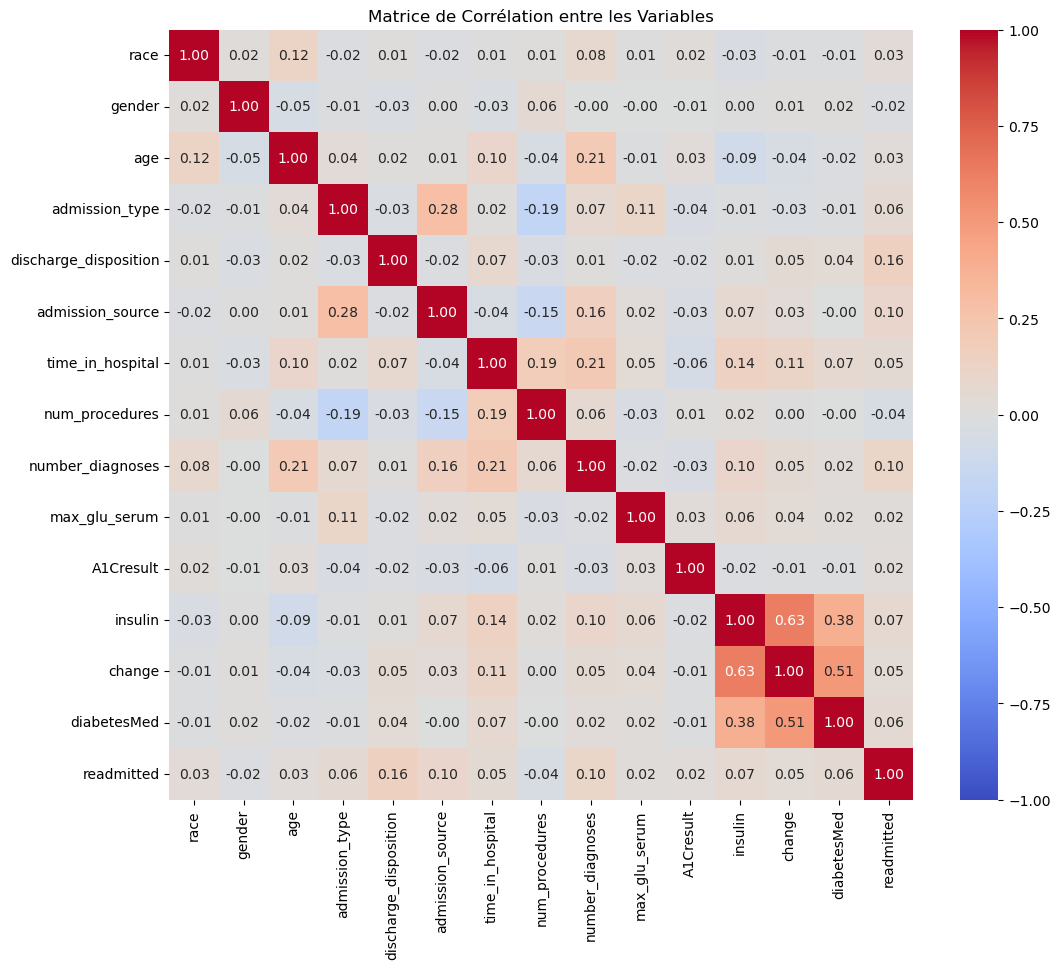

In [37]:
# Calcul de la matrice de corrélation
correlation_matrix = df1[colonnes_selected].corr()

# Paramètres de la figure
plt.figure(figsize=(12, 10))

# Création de la carte de corrélation avec une palette de couleurs
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Ajout du titre
plt.title('Matrice de Corrélation entre les Variables')

# Affichage de la carte de corrélation
plt.show()

We can see that readmitted seems to not be  a lot correlated to any of this variables.

We could creat a new variable readmission_nbr that calculate the number of time the patient is on the dataset. Which correspond to the number of new registration of the patient.

We discided to creat this variable now and to not keep it during the study because this variable may consider the futur information of the patient (number of time he is going to come back) as we are not sure of the encounters time order.
We need to only use present data to predict so this model could be use in real life.

In [38]:
df1['readmission_nbr'] = df1.groupby('patient_nbr')['patient_nbr'].transform('count')
#on réaffiche la matrice de corrélation
colonnes_selected2=['readmission_nbr','race','gender','age','admission_type','time_in_hospital','num_procedures', 'number_diagnoses', 'max_glu_serum', 'A1Cresult','insulin','change', 'diabetesMed', 'readmitted']

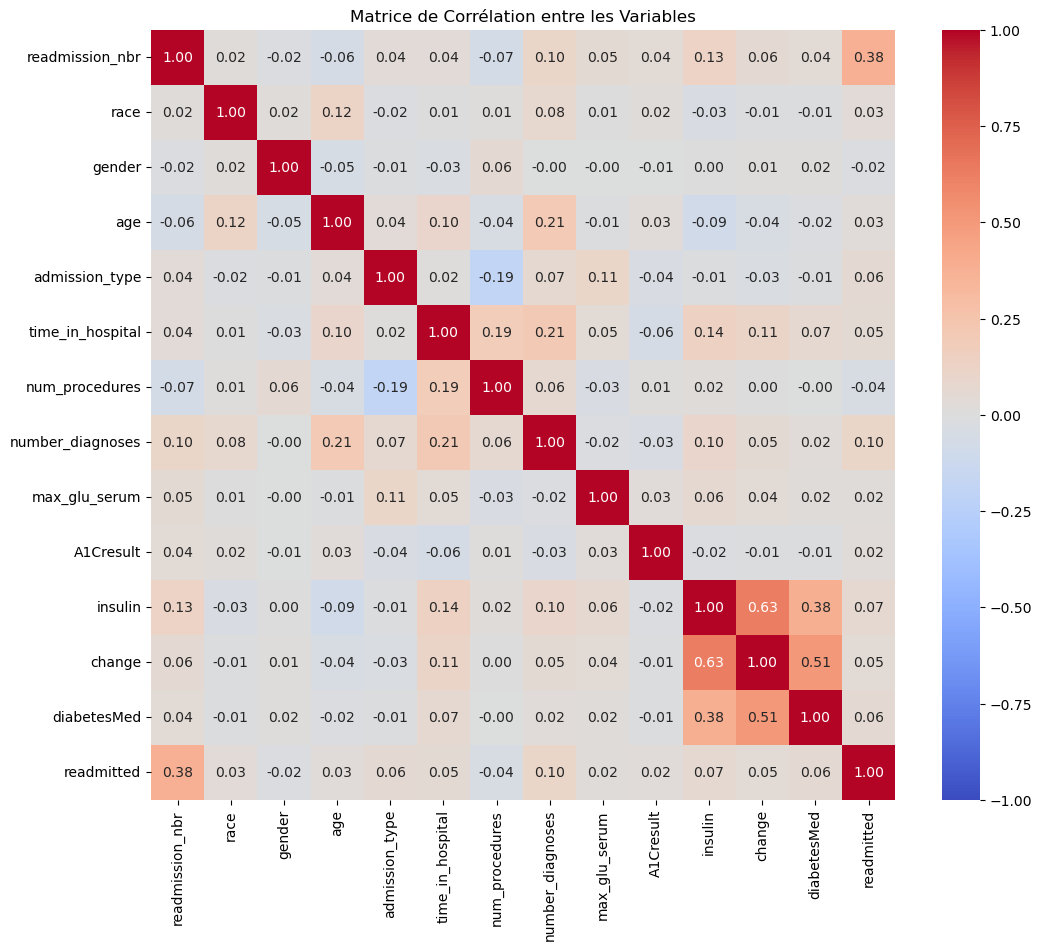

In [39]:
# Calcul de la matrice de corrélation
correlation_matrix = df1[colonnes_selected2].corr()

# Paramètres de la figure
plt.figure(figsize=(12, 10))

# Création de la carte de corrélation avec une palette de couleurs
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Ajout du titre
plt.title('Matrice de Corrélation entre les Variables')

# Affichage de la carte de corrélation
plt.show()

We can see the clear correlation between readmission_nbr and readmitted.

Now we can look at the correlation matrix with the one hot encoding:

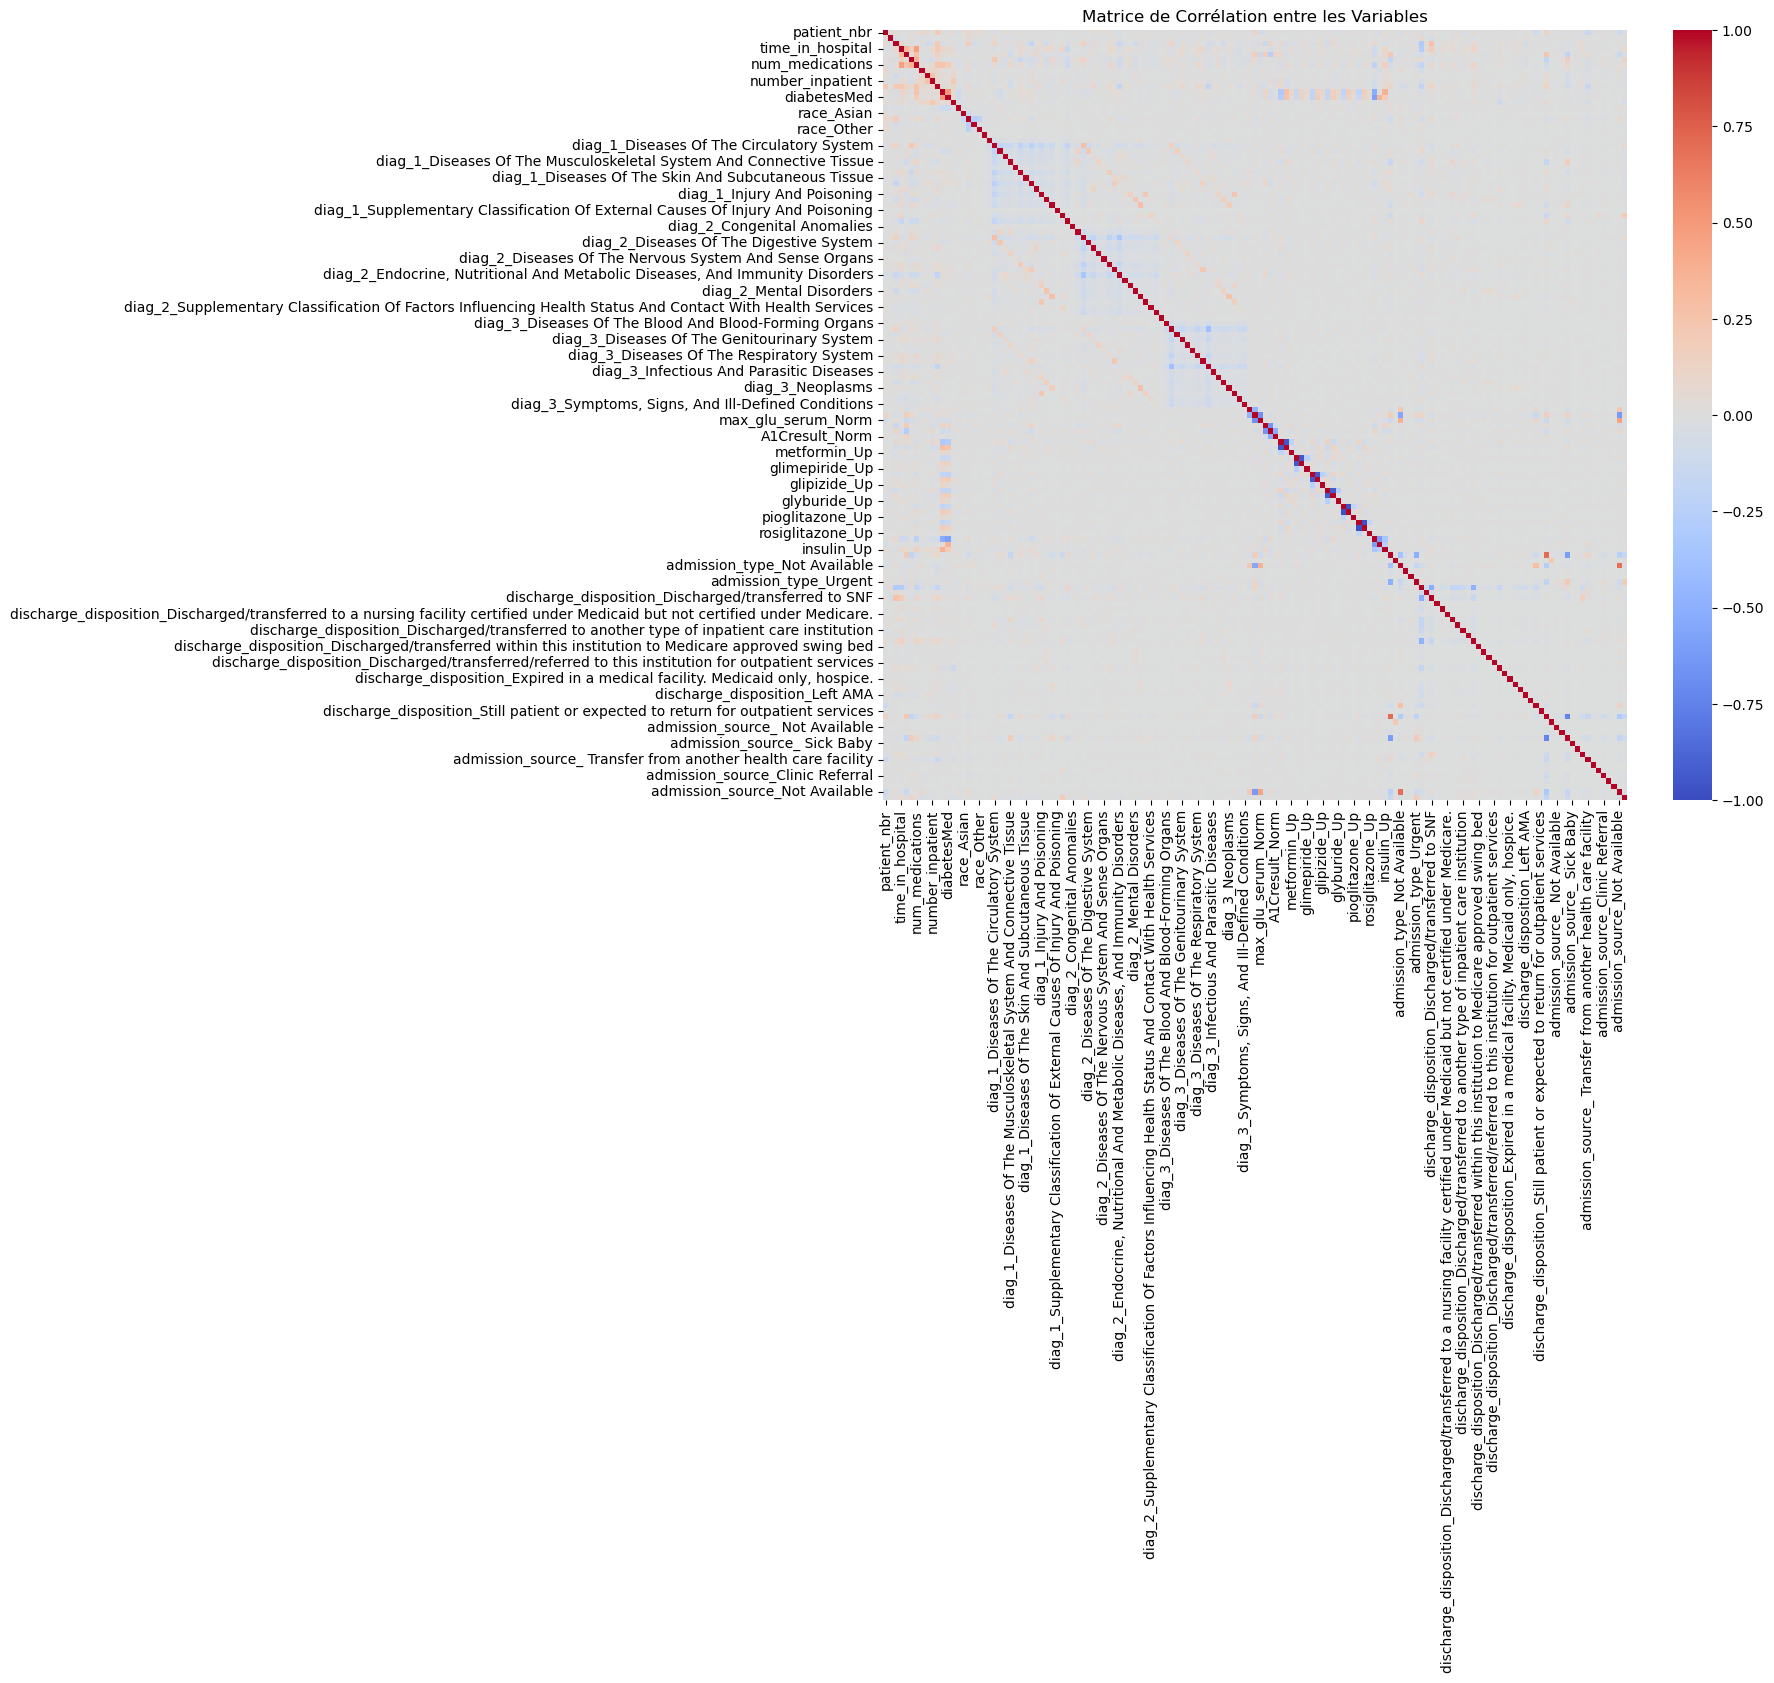

In [40]:
correlation_matrix = df2.corr()

plt.figure(figsize=(12, 10))

# Création de la carte de corrélation avec une palette de couleurs
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)

# Ajout du titre
plt.title('Matrice de Corrélation entre les Variables')

# Affichage de la carte de corrélation
plt.show()


Again it is hard to read, we can focus on our target variable: 

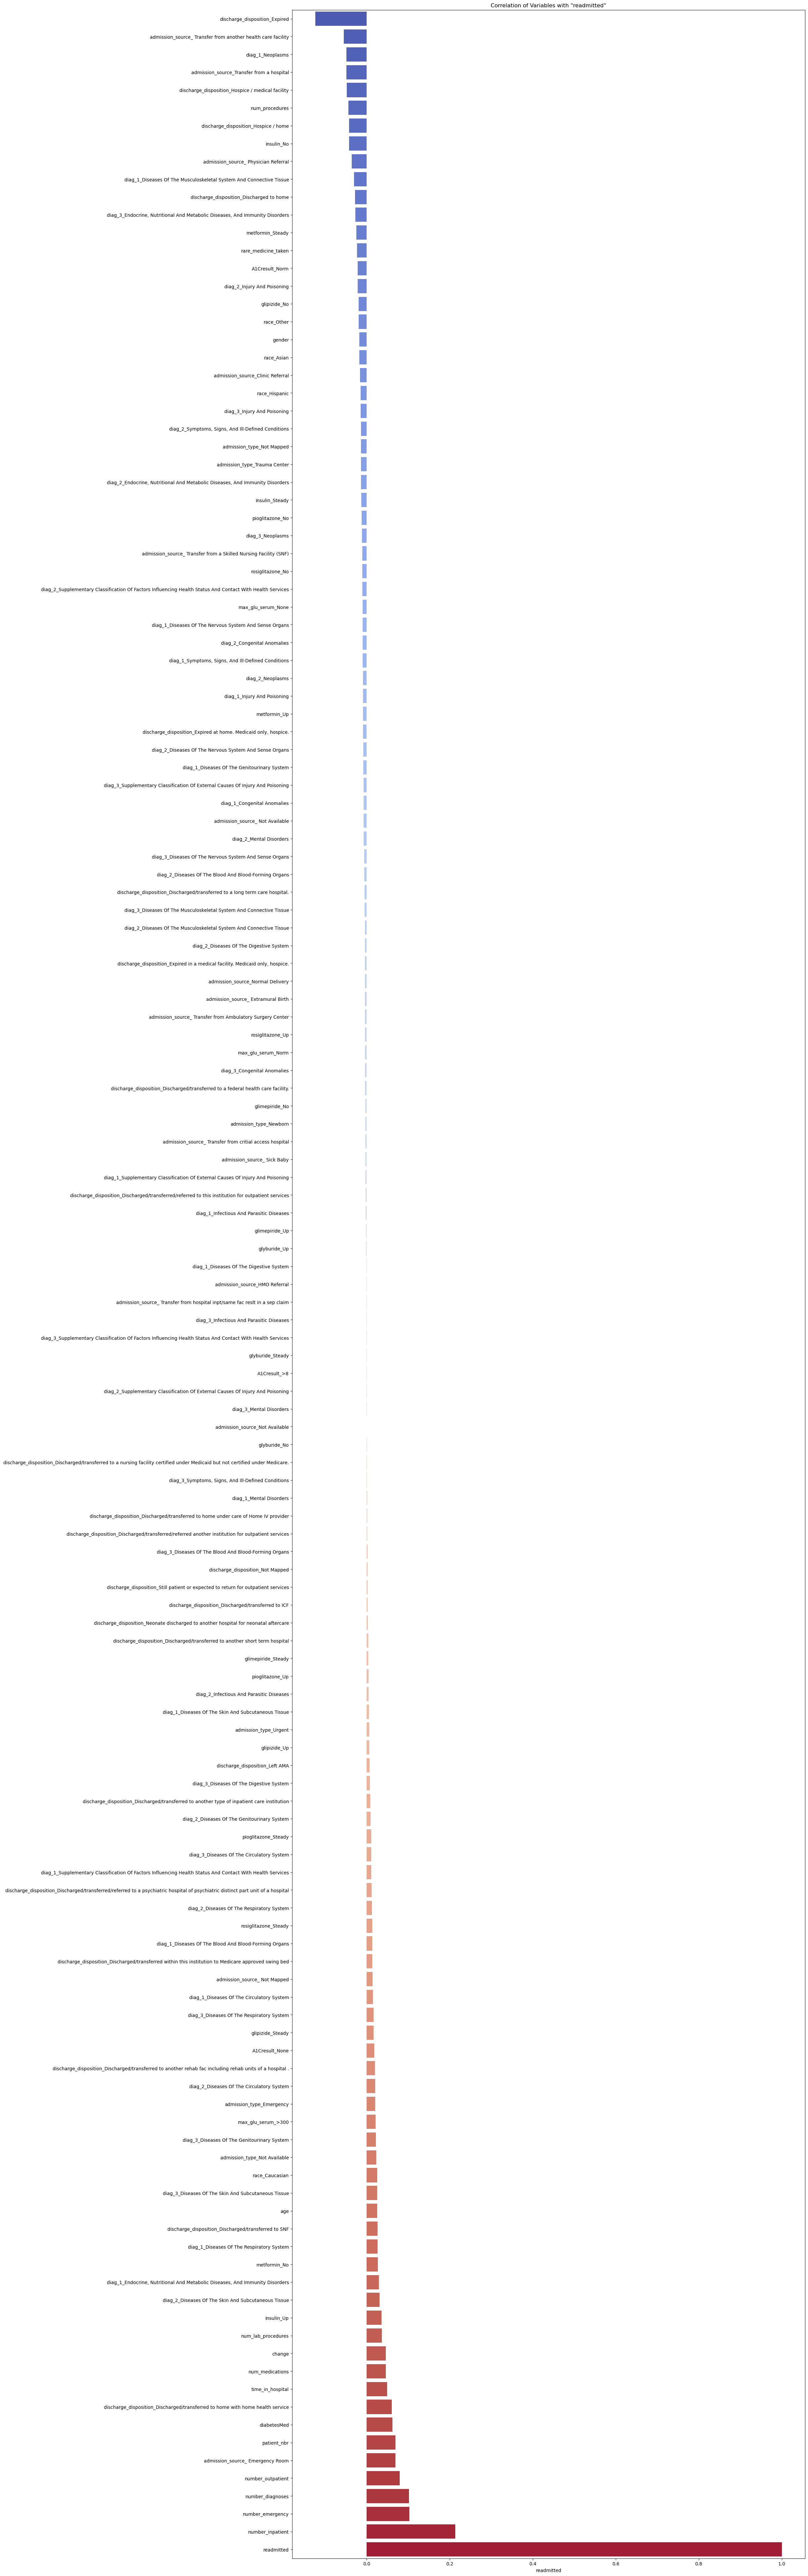

In [41]:
# Extract the correlation values for 'readmitted' column
readmitted_corr = correlation_matrix['readmitted']

# Sort the correlation values in ascending order
readmitted_corr_sorted = readmitted_corr.sort_values()

# Plotting the horizontal bar plot
plt.figure(figsize=(20, 100))
sns.barplot(x=readmitted_corr_sorted, y=readmitted_corr_sorted.index, palette='coolwarm')

# Adding the title
plt.title('Correlation of Variables with "readmitted"')

# Display the plot
plt.show()


Some variable such as number of inpatient, emergency, diagnoses or outpatient seems to be the more correlated to our target. A lot of variables ar almost not correlated at all. This does not mean that there will be useless for the prediction as the correlation may not be linear.

## Link between our dataset and discret values

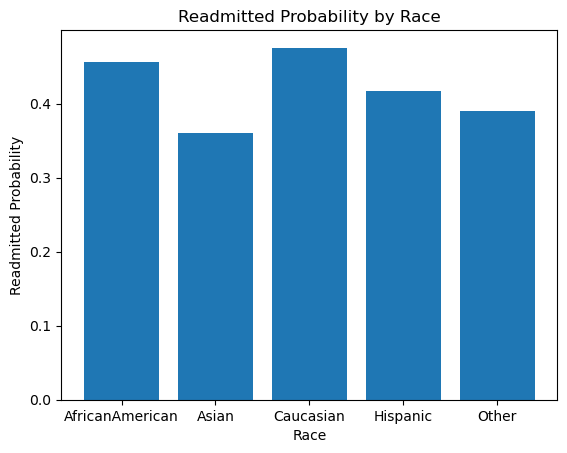

In [42]:
# Calculate the mean readmission probability for each race category
mean_prob = df.groupby('race')['readmitted'].mean()

# Create the bar plot
plt.bar(mean_prob.index, mean_prob)
plt.title("Readmitted Probability by Race")
plt.xlabel("Race")
plt.ylabel("Readmitted Probability")

# Show the plot
plt.show()

We can see a clear different of readmition probabilty depending on some race (between Asian and AfricanAmerican)

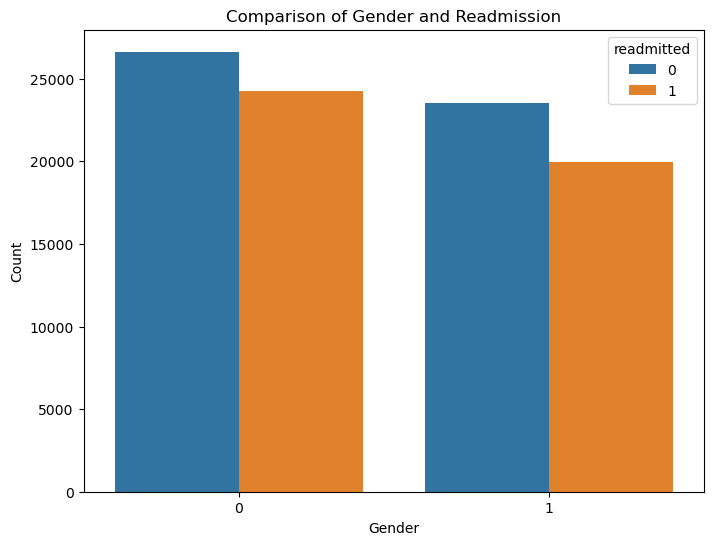

In [53]:
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='readmitted', data=df)
plt.title('Comparison of Gender and Readmission')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

The gender does not seems to have an impact on the readmission

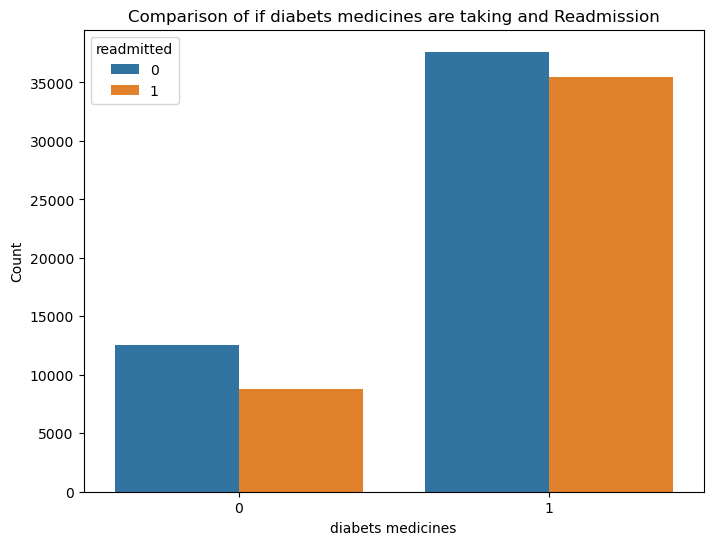

In [43]:
plt.figure(figsize=(8, 6))
sns.countplot(x='diabetesMed', hue='readmitted', data=df)
plt.title('Comparison of if diabets medicines are taking and Readmission')
plt.xlabel('diabets medicines')
plt.ylabel('Count')
plt.show()

Same for the consomation of diabets medicines

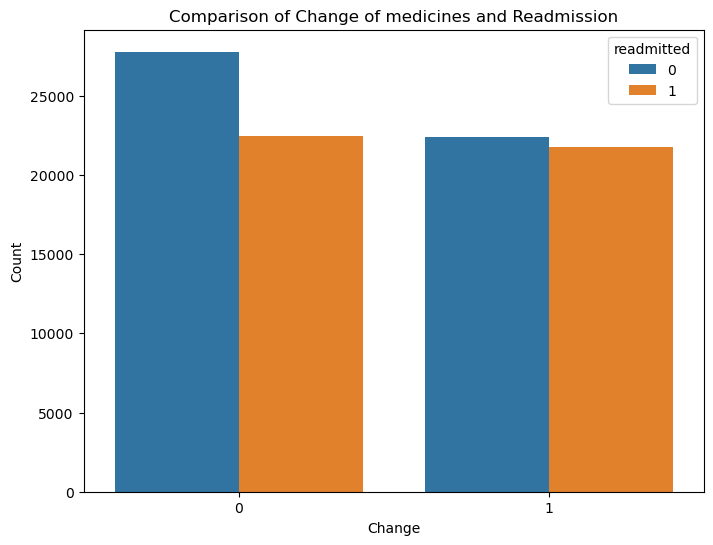

In [55]:
plt.figure(figsize=(8, 6))
sns.countplot(x='change', hue='readmitted', data=df)
plt.title('Comparison of Change of medicines and Readmission')
plt.xlabel('Change')
plt.ylabel('Count')
plt.show()

On the other hand, the change of medicines seems to increase the readmission probability.

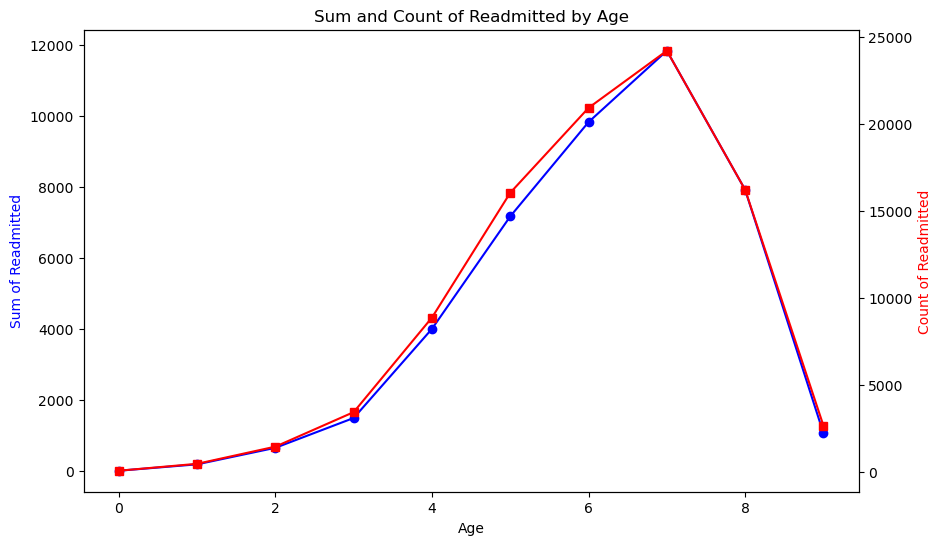

In [44]:
# Calculate the sum and count of readmitted for each age group
age_groups = df.groupby('age')['readmitted'].agg(['sum', 'count'])

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the sum of readmitted
ax1.plot(age_groups.index, age_groups['sum'], color='blue', marker='o')
ax1.set_xlabel("Age")
ax1.set_ylabel("Sum of Readmitted", color='blue')

# Create a twin axis sharing the x-axis
ax2 = ax1.twinx()

# Plot the count of readmitted
ax2.plot(age_groups.index, age_groups['count'], color='red', marker='s')
ax2.set_ylabel("Count of Readmitted", color='red')

# Set the title
plt.title("Sum and Count of Readmitted by Age")

# Show the plot
plt.show()

We can see that the two curves have almost the same shape. The age does not seem to have an impact on the readmitions. Overwis the number of readmissions is slitly lower around 50/60 years olds patients.

### Medicines

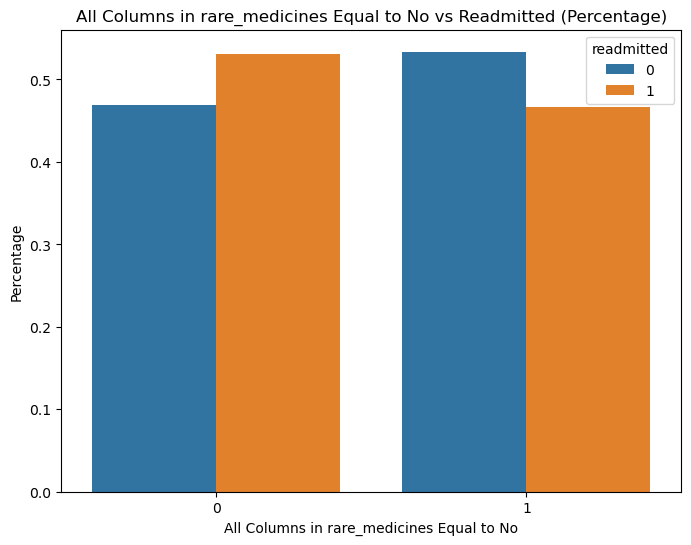

In [57]:
plt.figure(figsize=(8, 6))

# Calculate percentage of 'readmitted' for each category
data_percentage = (
    df.groupby(['rare_medicine_taken', 'readmitted']).size() / df.groupby('rare_medicine_taken').size()
).reset_index(name='percentage')

# Create a bar plot
sns.barplot(x='rare_medicine_taken', y='percentage', hue='readmitted', data=data_percentage)

plt.title('All Columns in rare_medicines Equal to No vs Readmitted (Percentage)')
plt.xlabel('All Columns in rare_medicines Equal to No')
plt.ylabel('Percentage')
plt.show()

The number of people readmitted is higher when they are not taking rare medicines. 

Let's have a closer look to the other medicines:

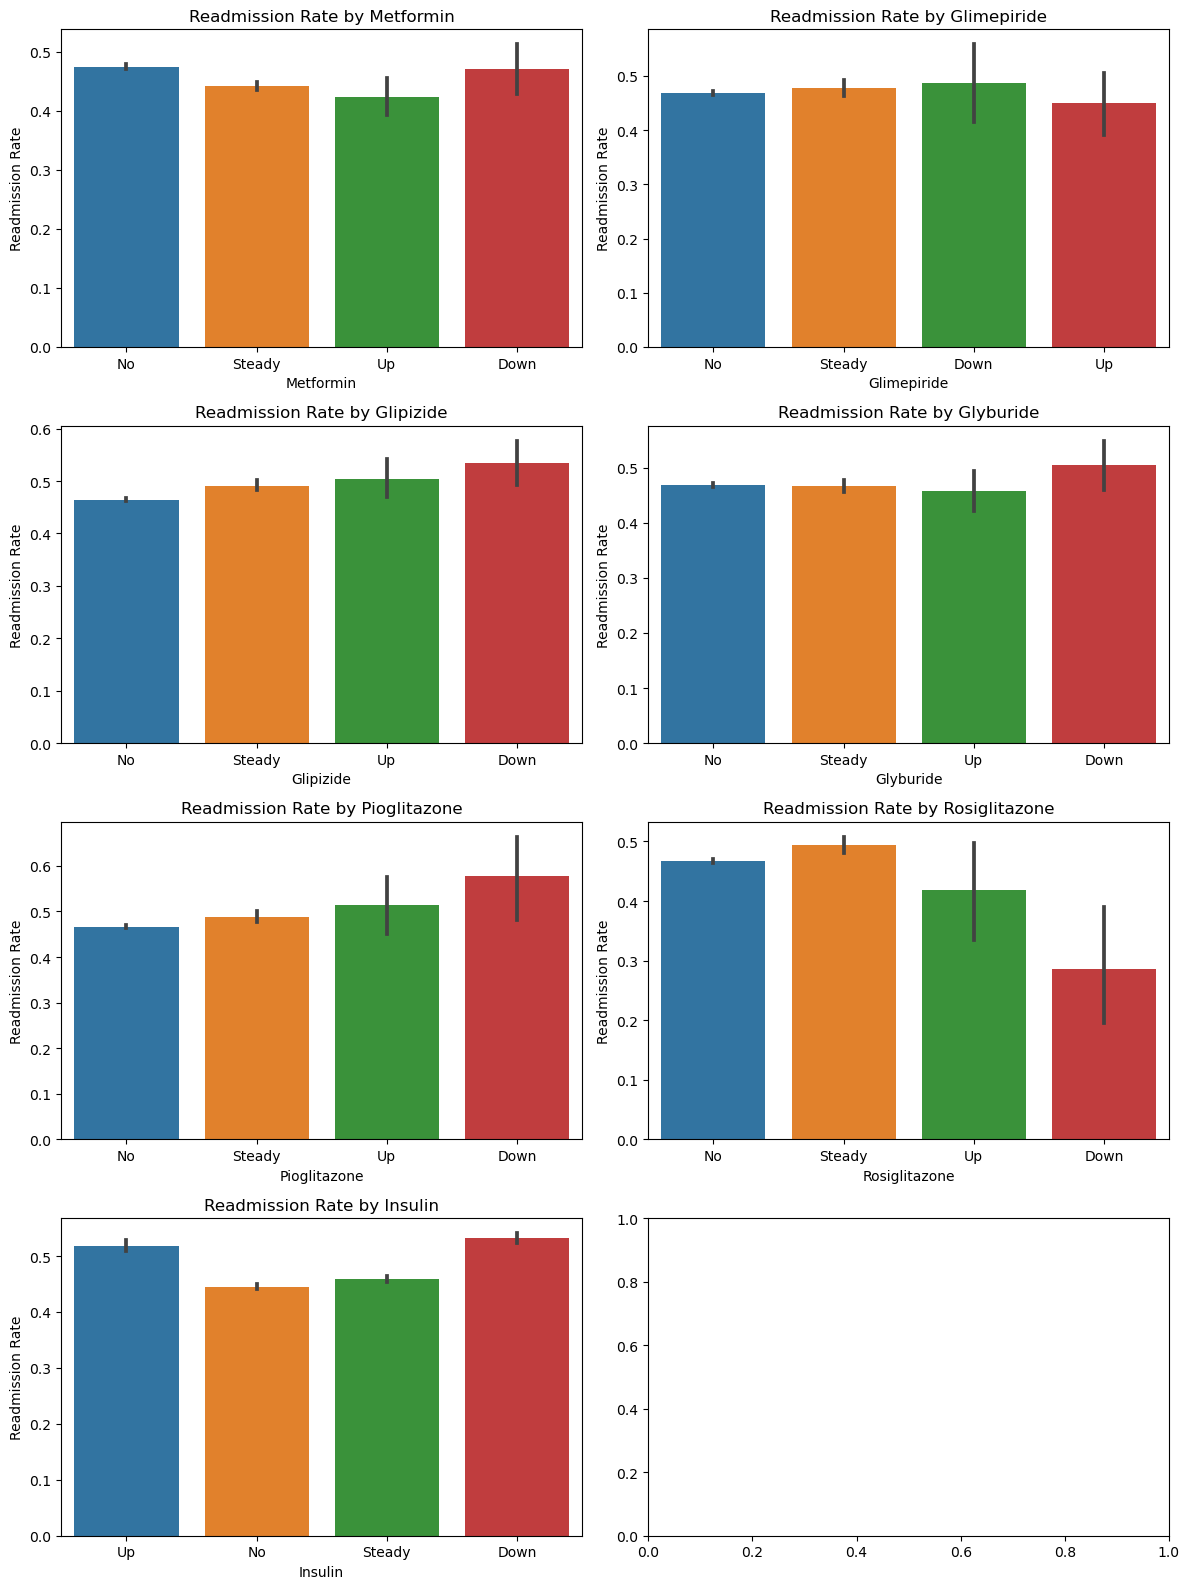

In [45]:
# Create a subset of the DataFrame with the relevant columns
subset = df[['metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone','rosiglitazone', 'insulin','readmitted']]

# Plot multiple bar plots in a grid layout
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

# Iterate over each column and create a bar plot
for i, col in enumerate(subset.columns[:-1]):
    sns.barplot(x=col, y='readmitted', data=subset, ax=axes[i])
    axes[i].set_title(f'Readmission Rate by {col.capitalize()}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Readmission Rate')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

We can say that each medicine consomation has his own impact on the readmission of the patient. It is a good thing to keep them separate in the dataset as the correlations are not the same with the target variable.

### Admission Type

We are plotting the same graphs fo the three categories Admission type, admsission source and discharge disposition. The first one to see the repartition of the values, then the proportion of readmitted depending on the values.Finally we are looking for correlation between the category and the medical tests max_glu_serum and A1Cresult. For each of the category variables where the all the tests variable are equaly represented we will look if the test result has an impact on the readmition in this category value.

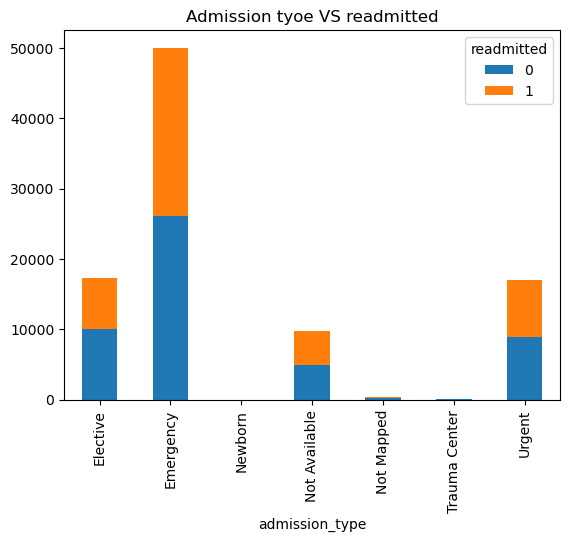

In [46]:
crosstab_df = pd.crosstab(df['admission_type'],df['readmitted'])
crosstab_df.plot(kind='bar', stacked=True)
plt.title('Admission tyoe VS readmitted')
plt.show()

There are clearly 4 main admission type.

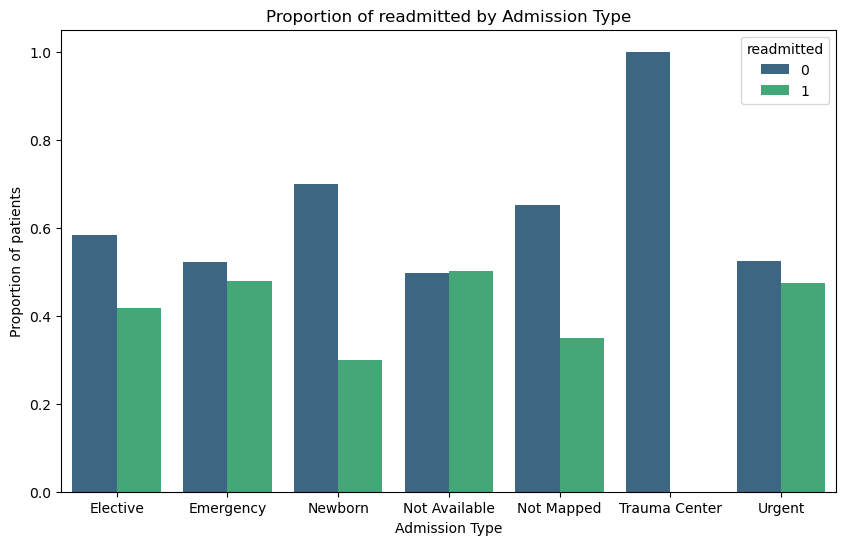

In [47]:
df_counts = df[['readmitted', 'admission_type']].groupby(['admission_type', 'readmitted']).size().reset_index(name='count')

# Calculate proportions within each 'admission_type'
df_counts['proportion'] = df_counts.groupby('admission_type')['count'].transform(lambda x: x / x.sum())

# Plotting the count plot with proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='admission_type', y='proportion', hue='readmitted', data=df_counts, palette='viridis')

# Adding labels and title
plt.xlabel('Admission Type')
plt.ylabel('Proportion of patients')
plt.title('Proportion of readmitted by Admission Type')

# Display the plot
plt.show()

Each admission type has its own readmitted proportion. But from the 4 main represented on the dataset one is mostly different from the over: Not Available with a majority of readmitted.

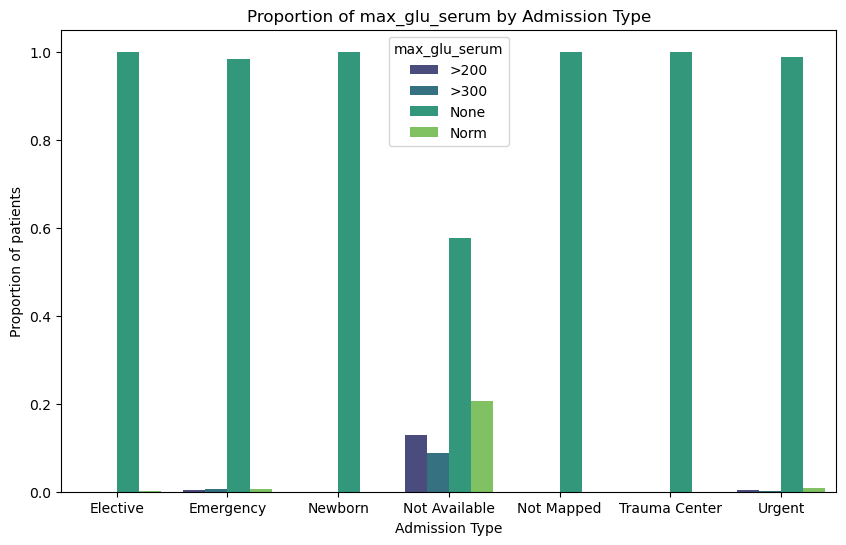

In [61]:
# Assuming df is your DataFrame
df_counts = df[['max_glu_serum', 'admission_type']].groupby(['admission_type', 'max_glu_serum']).size().reset_index(name='count')

# Calculate proportions within each 'admission_type'
df_counts['proportion'] = df_counts.groupby('admission_type')['count'].transform(lambda x: x / x.sum())

# Plotting the count plot with proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='admission_type', y='proportion', hue='max_glu_serum', data=df_counts, palette='viridis')

# Adding labels and title
plt.xlabel('Admission Type')
plt.ylabel('Proportion of patients')
plt.title('Proportion of max_glu_serum by Admission Type')

# Display the plot
plt.show()

At the same time Not Available is the only category where all max_glu_serum results are well represented.

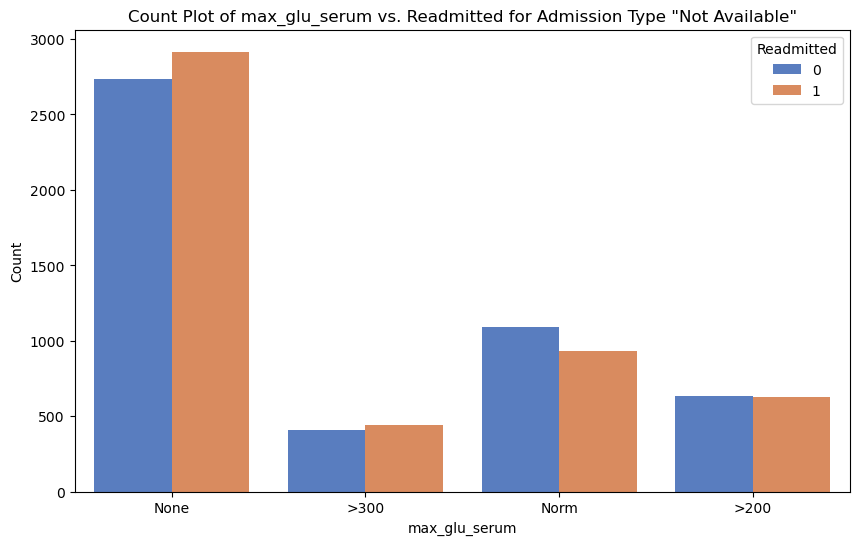

In [62]:
subset_df = df[df['admission_type'] == 'Not Available']

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='max_glu_serum', hue='readmitted', data=subset_df, palette="muted")

# Customize the plot
plt.title('Count Plot of max_glu_serum vs. Readmitted for Admission Type "Not Available"')
plt.xlabel('max_glu_serum')
plt.ylabel('Count')
plt.legend(title="Readmitted", loc="upper right")
plt.show()

By looking closer we can see that even the None column (the one represented in the over admission type) has a majority of readmitted. So it is not linked to the number of max_glu_serum test taken.

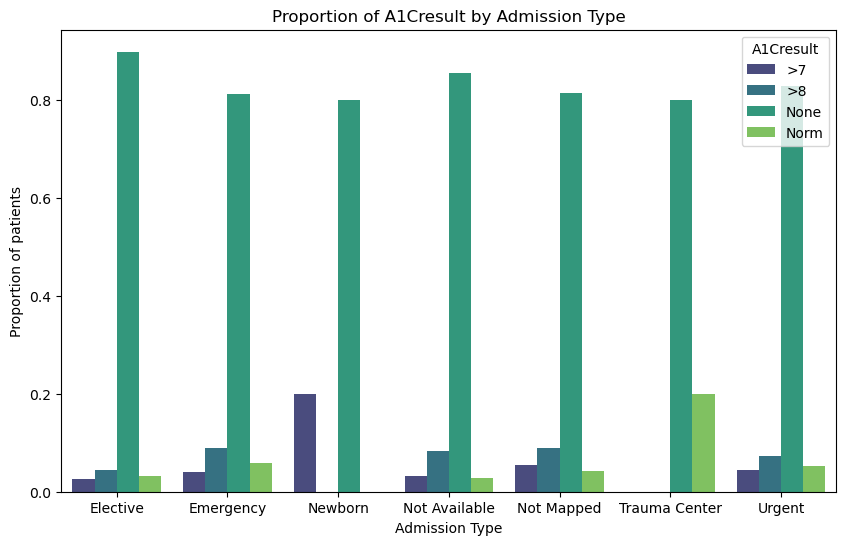

In [48]:
df_counts = df[['A1Cresult', 'admission_type']].groupby(['admission_type', 'A1Cresult']).size().reset_index(name='count')

# Calculate proportions within each 'admission_type'
df_counts['proportion'] = df_counts.groupby('admission_type')['count'].transform(lambda x: x / x.sum())

# Plotting the count plot with proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='admission_type', y='proportion', hue='A1Cresult', data=df_counts, palette='viridis')

# Adding labels and title
plt.xlabel('Admission Type')
plt.ylabel('Proportion of patients')
plt.title('Proportion of A1Cresult by Admission Type')

# Display the plot
plt.show()

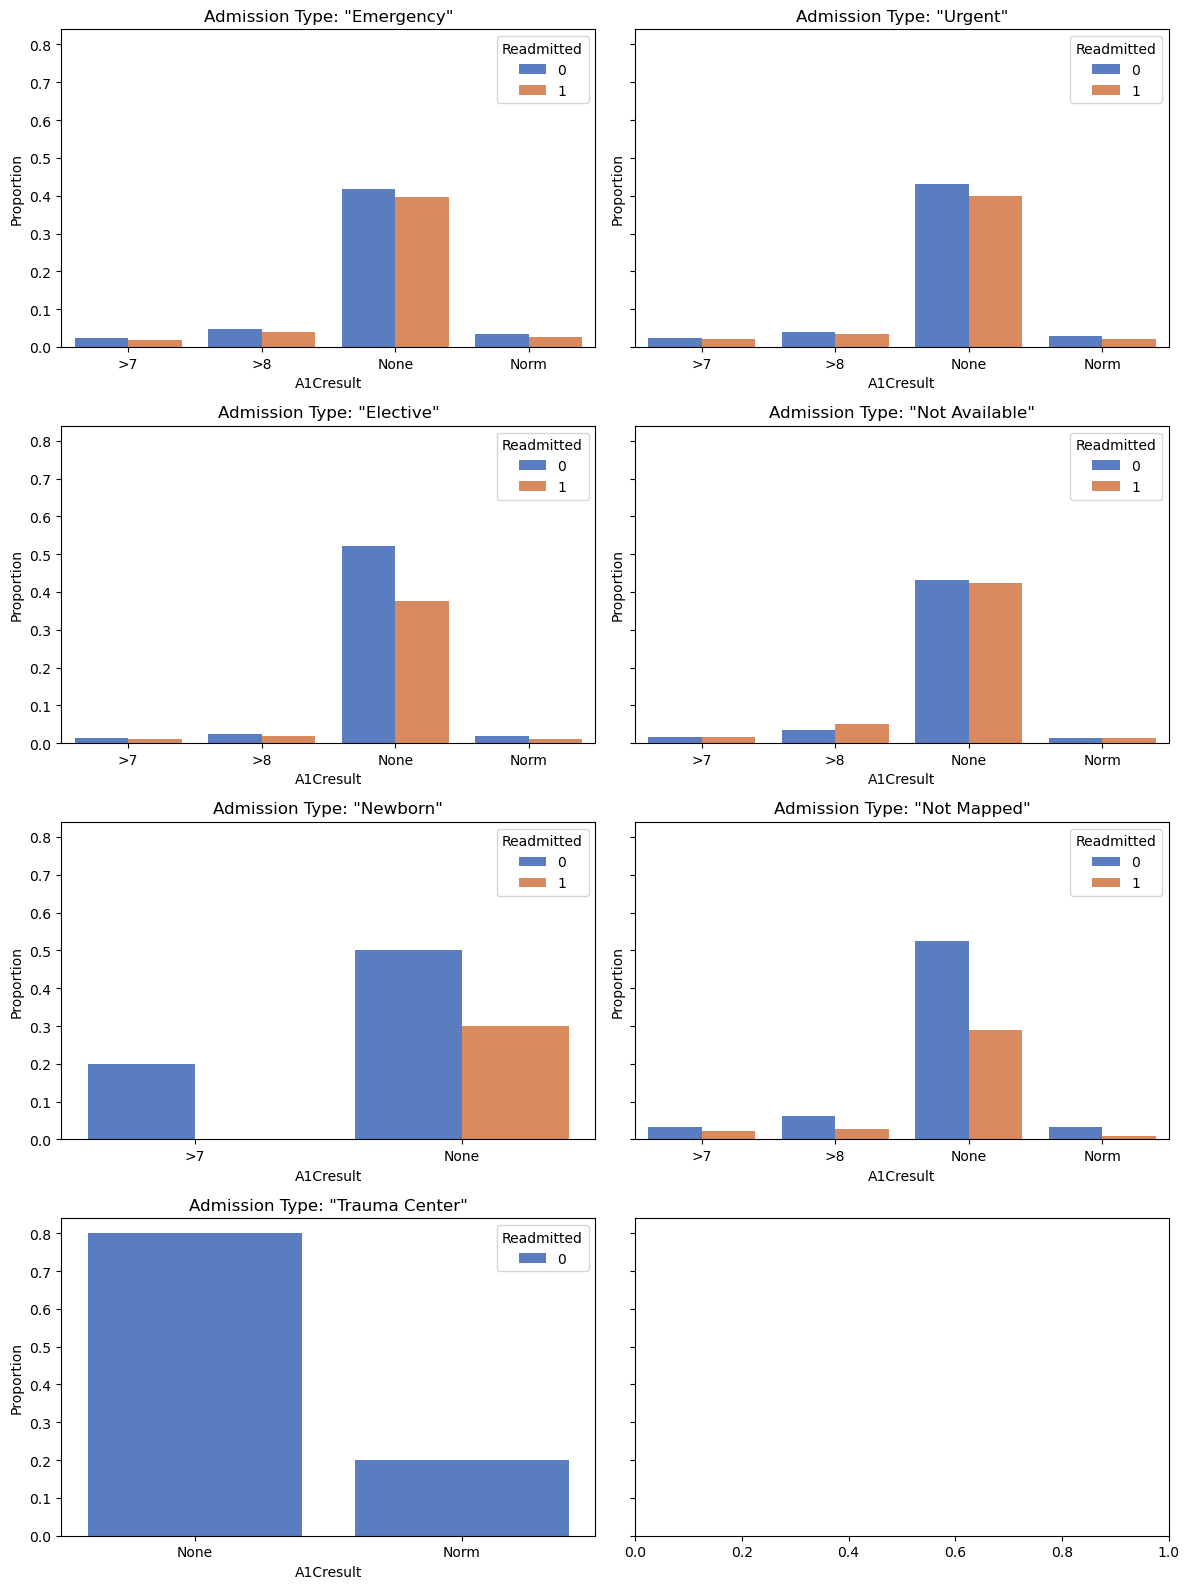

In [49]:
# Get unique values of 'admission_type'
admission_types = df['admission_type'].unique()

# Set up subplots with a 4x2 grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16), sharey=True)

# Loop through each admission_type and create a count plot in the corresponding subplot
for i, admission_type in enumerate(admission_types):
    # Calculate the row and column indices
    row_idx, col_idx = divmod(i, 2)

    # Create a subset of the data for the current admission_type
    subset_df = df[df['admission_type'] == admission_type]

    # Calculate proportions manually
    proportions = subset_df.groupby(['A1Cresult', 'readmitted']).size() / len(subset_df)
    proportions = proportions.reset_index(name='proportion')

    # Create the bar plot with normalization
    sns.barplot(x='A1Cresult', y='proportion', hue='readmitted', data=proportions, palette="muted", ax=axes[row_idx, col_idx])

    # Customize the plot
    axes[row_idx, col_idx].set_title(f'Admission Type: "{admission_type}"')
    axes[row_idx, col_idx].set_xlabel('A1Cresult')
    axes[row_idx, col_idx].set_ylabel('Proportion')
    axes[row_idx, col_idx].legend(title="Readmitted", loc="upper right")

# Adjust layout
plt.tight_layout()
plt.show()


### Admission source

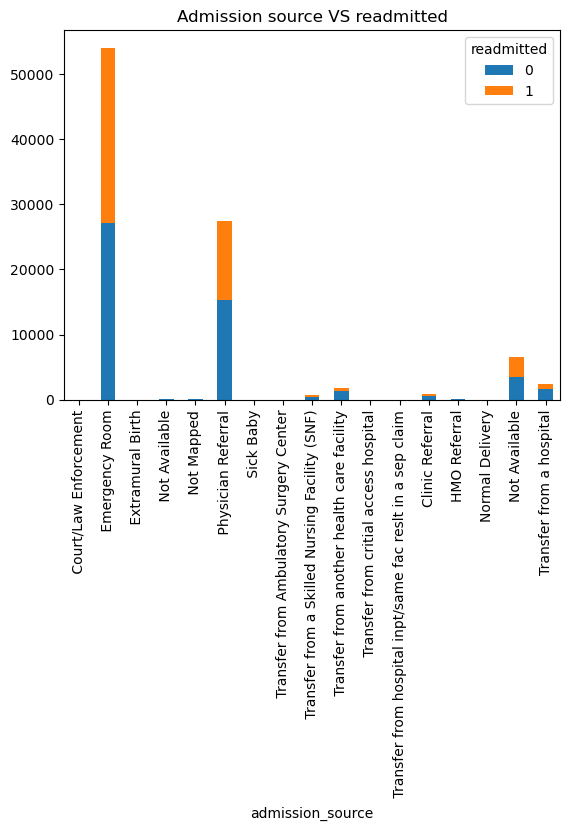

In [65]:
crosstab_df = pd.crosstab(df['admission_source'],df['readmitted'])
crosstab_df.plot(kind='bar', stacked=True)
plt.title('Admission source VS readmitted')
plt.show()

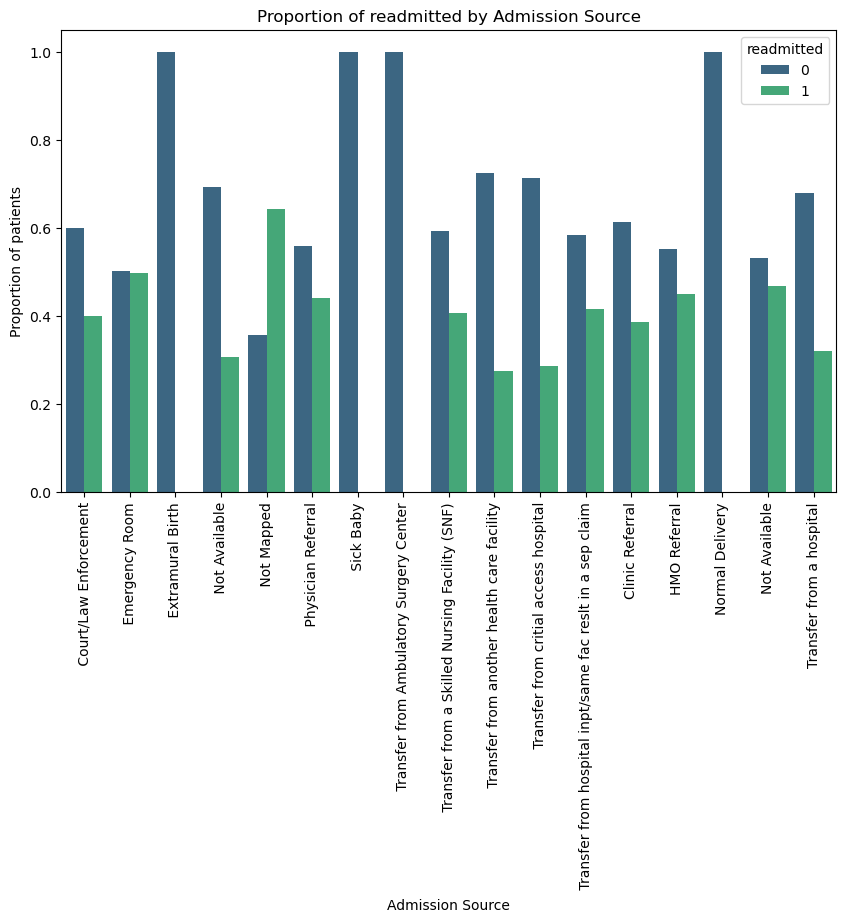

In [66]:
# Calculate counts and proportions within each 'admission_source'
df_counts = df[['readmitted', 'admission_source']].groupby(['admission_source', 'readmitted']).size().reset_index(name='count')
df_counts['proportion'] = df_counts.groupby('admission_source')['count'].transform(lambda x: x / x.sum())

# Plotting the count plot with proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='admission_source', y='proportion', hue='readmitted', data=df_counts, palette='viridis')

# Adding labels and title
plt.xlabel('Admission Source')
plt.ylabel('Proportion of patients')
plt.title('Proportion of readmitted by Admission Source')

plt.xticks(rotation=90)

# Display the plot
plt.show()

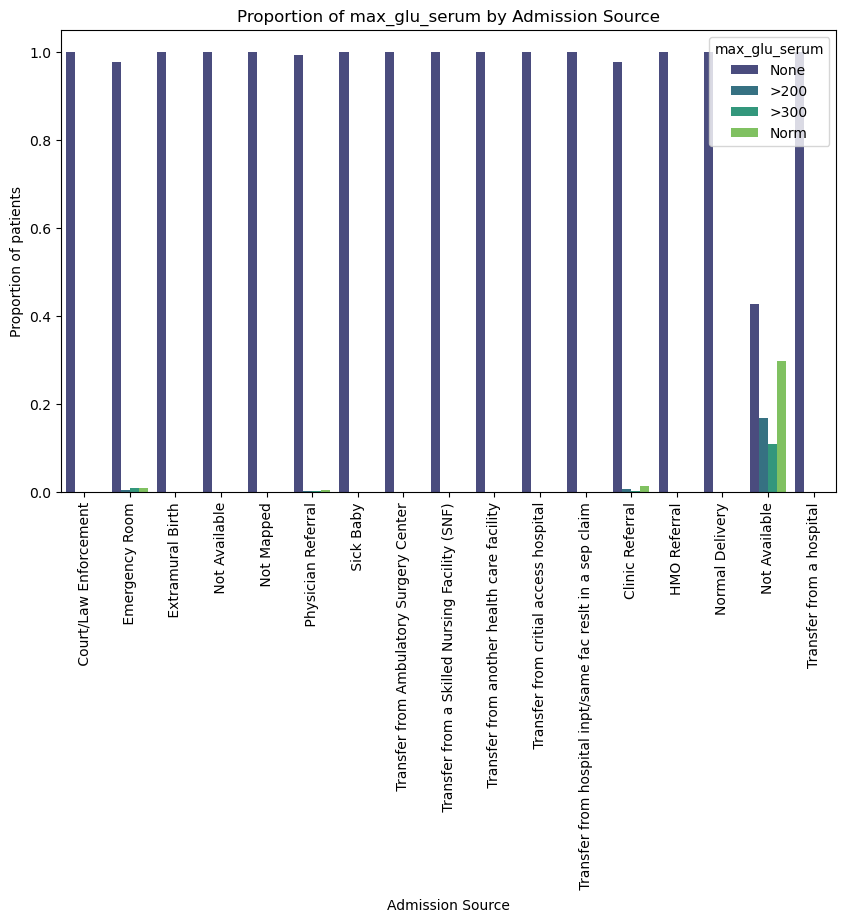

In [67]:
df_counts = df[['max_glu_serum', 'admission_source']].groupby(['admission_source', 'max_glu_serum']).size().reset_index(name='count')

# Calculate proportions within each 'admission_source'
df_counts['proportion'] = df_counts.groupby('admission_source')['count'].transform(lambda x: x / x.sum())

# Plotting the count plot with proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='admission_source', y='proportion', hue='max_glu_serum', data=df_counts, palette='viridis')

# Adding labels and title
plt.xlabel('Admission Source')
plt.ylabel('Proportion of patients')
plt.title('Proportion of max_glu_serum by Admission Source')

# Display the plot
plt.xticks(rotation=90)
plt.show()

It is the opposit than before. Not Available has les readmitted patient while still being the only one with a good representation of the max_glu_serum test results.

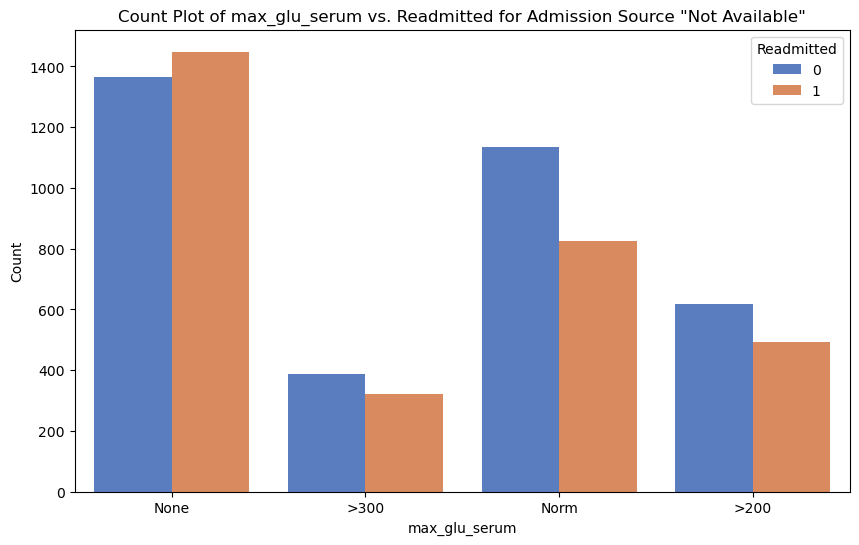

In [68]:
subset_df = df[df['admission_source'] == 'Not Available']

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='max_glu_serum', hue='readmitted', data=subset_df, palette="muted")

# Customize the plot
plt.title('Count Plot of max_glu_serum vs. Readmitted for Admission Source "Not Available"')
plt.xlabel('max_glu_serum')
plt.ylabel('Count')
plt.legend(title="Readmitted", loc="upper right")
plt.show()

But here it seems to be du to the presence of patient who did the test (less chance to be readmitted)

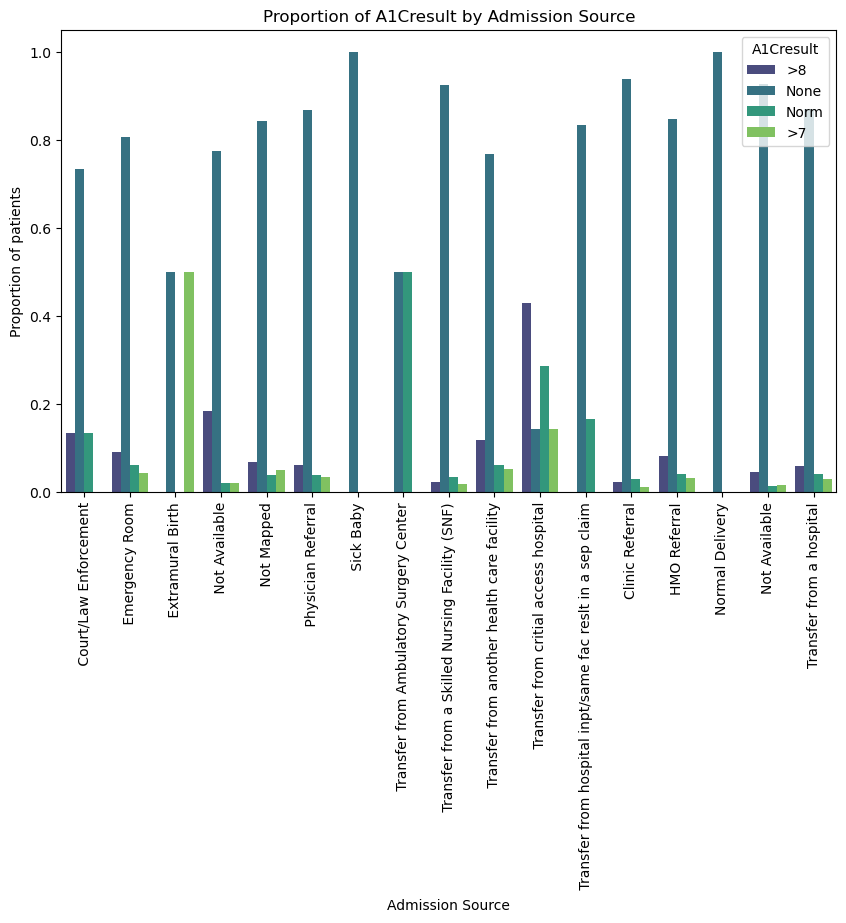

In [50]:
df_counts = df[['A1Cresult', 'admission_source']].groupby(['admission_source', 'A1Cresult']).size().reset_index(name='count')

# Calculate proportions within each 'admission_type'
df_counts['proportion'] = df_counts.groupby('admission_source')['count'].transform(lambda x: x / x.sum())

# Plotting the count plot with proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='admission_source', y='proportion', hue='A1Cresult', data=df_counts, palette='viridis')

# Adding labels and title
plt.xlabel('Admission Source')
plt.ylabel('Proportion of patients')
plt.title('Proportion of A1Cresult by Admission Source')

# Display the plot
plt.xticks(rotation=90)
plt.show()

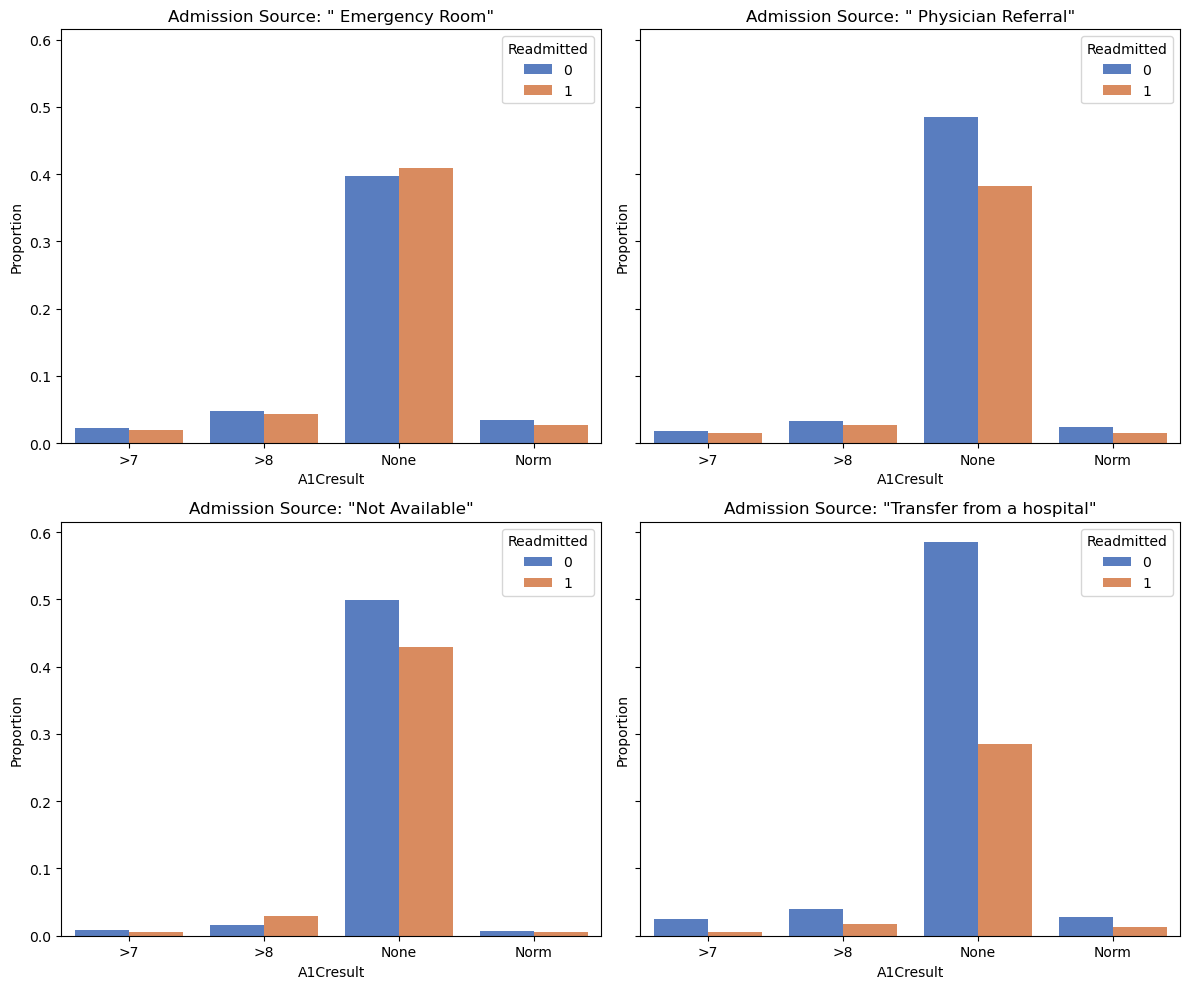

In [51]:
# Get the top 4 most represented admission sources
top_admission_sources = df['admission_source'].value_counts().nlargest(4).index

# Set up subplots with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True)

# Loop through each admission_source and create a bar plot in the corresponding subplot
for i, admission_source in enumerate(top_admission_sources):
    # Calculate the row and column indices
    row_idx, col_idx = divmod(i, 2)

    # Create a subset of the data for the current admission_source
    subset_df = df[df['admission_source'] == admission_source]

    # Calculate proportions manually
    proportions = subset_df.groupby(['A1Cresult', 'readmitted']).size() / len(subset_df)
    proportions = proportions.reset_index(name='proportion')

    # Create the bar plot with normalization
    sns.barplot(x='A1Cresult', y='proportion', hue='readmitted', data=proportions, palette="muted", ax=axes[row_idx, col_idx])

    # Customize the plot
    axes[row_idx, col_idx].set_title(f'Admission Source: "{admission_source}"')
    axes[row_idx, col_idx].set_xlabel('A1Cresult')
    axes[row_idx, col_idx].set_ylabel('Proportion')
    axes[row_idx, col_idx].legend(title="Readmitted", loc="upper right")

# Adjust layout
plt.tight_layout()
plt.show()






### Discharge disposition

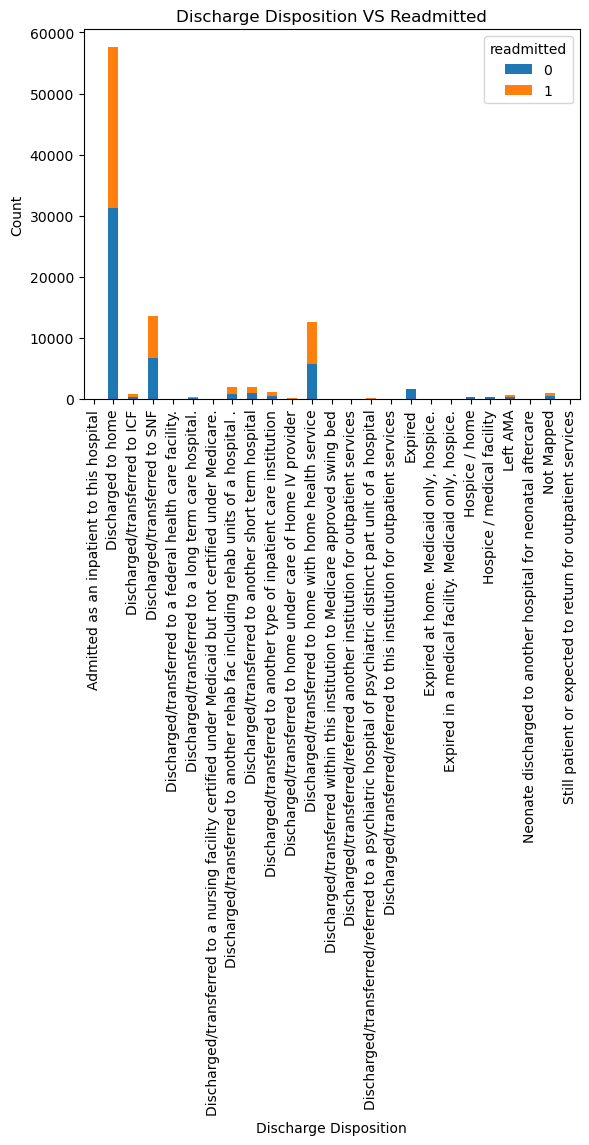

In [52]:
crosstab_df = pd.crosstab(df['discharge_disposition'], df['readmitted'])
crosstab_df.plot(kind='bar', stacked=True)
plt.title('Discharge Disposition VS Readmitted')
plt.xlabel('Discharge Disposition')
plt.ylabel('Count')

# Display the plot
plt.show()

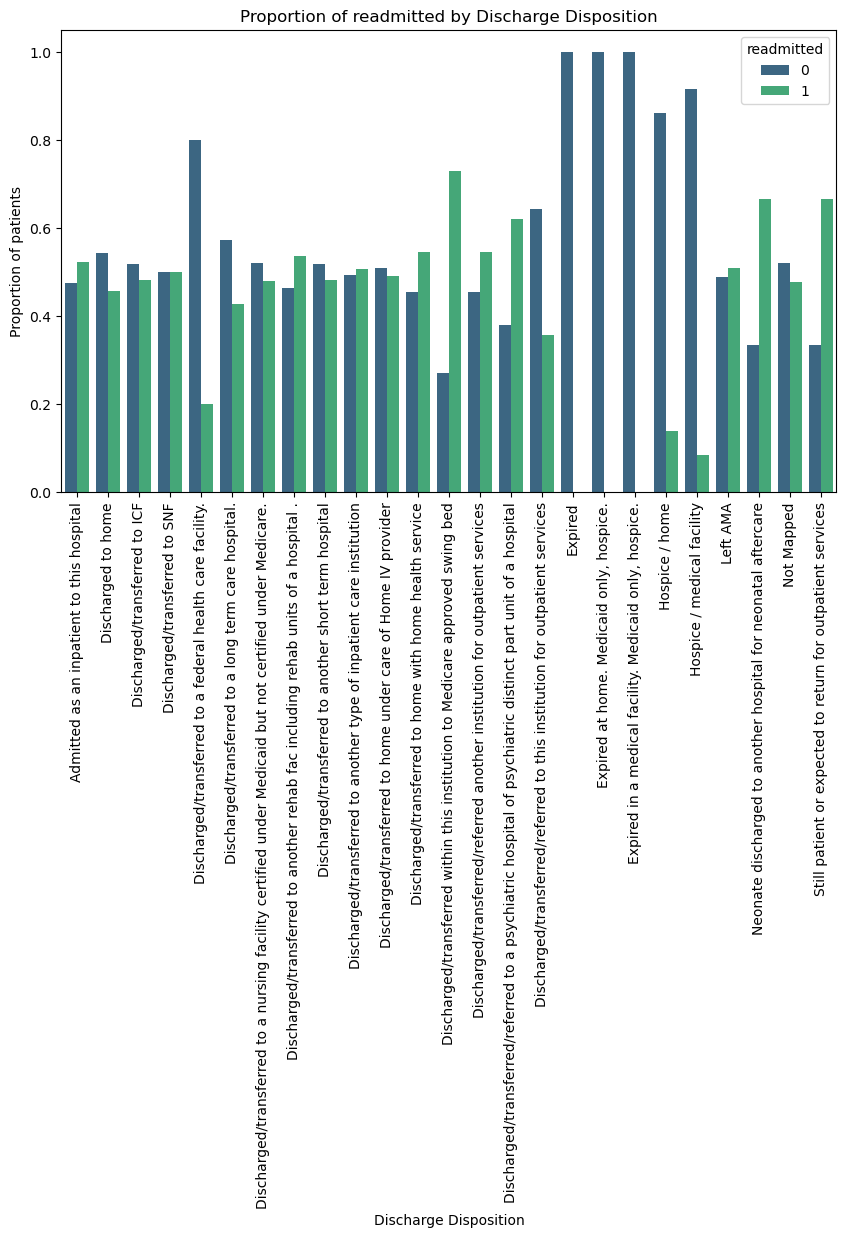

In [53]:
# Calculate counts and proportions within each 'discharge_disposition'
df_counts = df[['readmitted', 'discharge_disposition']].groupby(['discharge_disposition', 'readmitted']).size().reset_index(name='count')
df_counts['proportion'] = df_counts.groupby('discharge_disposition')['count'].transform(lambda x: x / x.sum())

# Plotting the stacked bar plot with proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='discharge_disposition', y='proportion', hue='readmitted', data=df_counts, palette='viridis')

# Adding labels and title
plt.xlabel('Discharge Disposition')
plt.ylabel('Proportion of patients')
plt.title('Proportion of readmitted by Discharge Disposition')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

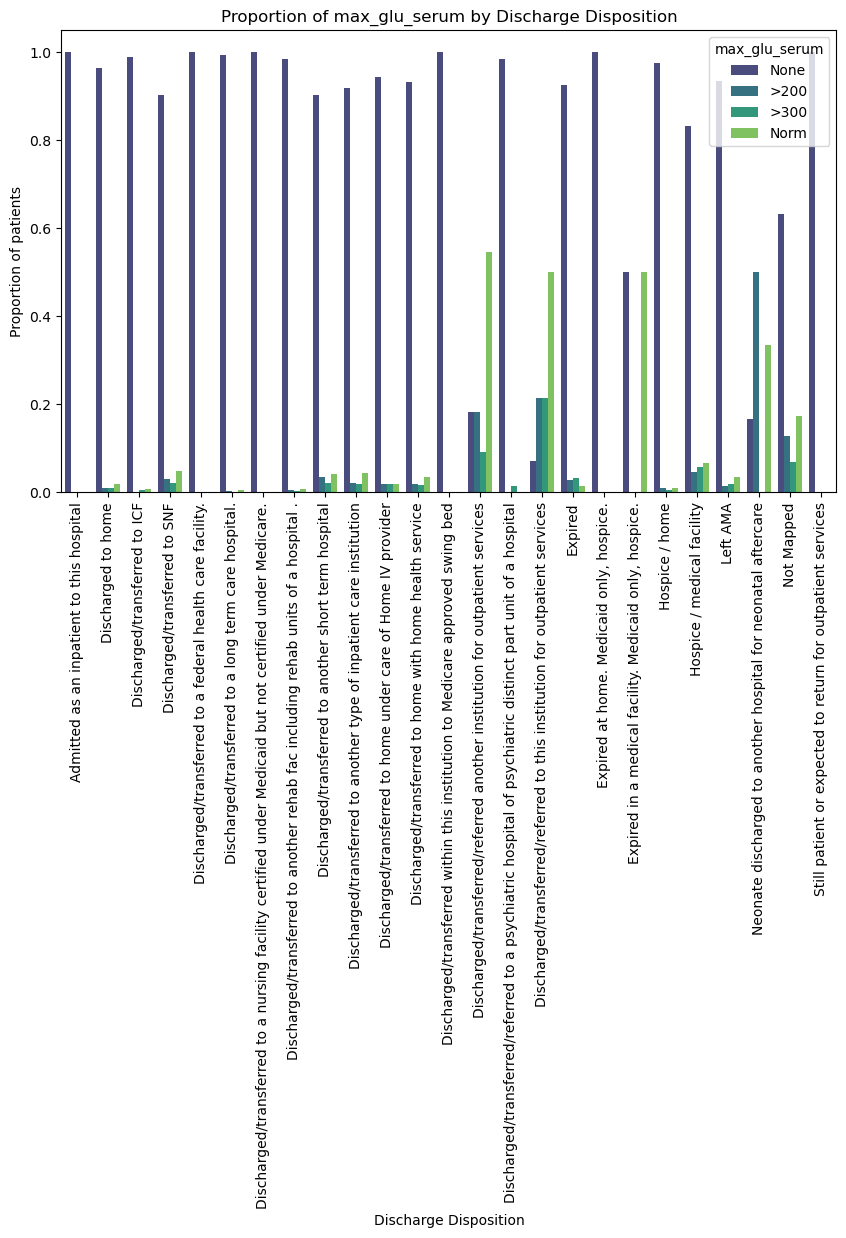

In [54]:
# Calculate counts and proportions within each 'discharge_disposition'
df_counts = df[['max_glu_serum', 'discharge_disposition']].groupby(['discharge_disposition', 'max_glu_serum']).size().reset_index(name='count')
df_counts['proportion'] = df_counts.groupby('discharge_disposition')['count'].transform(lambda x: x / x.sum())

# Plotting the count plot with proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='discharge_disposition', y='proportion', hue='max_glu_serum', data=df_counts, palette='viridis')

# Adding labels and title
plt.xlabel('Discharge Disposition')
plt.ylabel('Proportion of patients')
plt.title('Proportion of max_glu_serum by Discharge Disposition')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

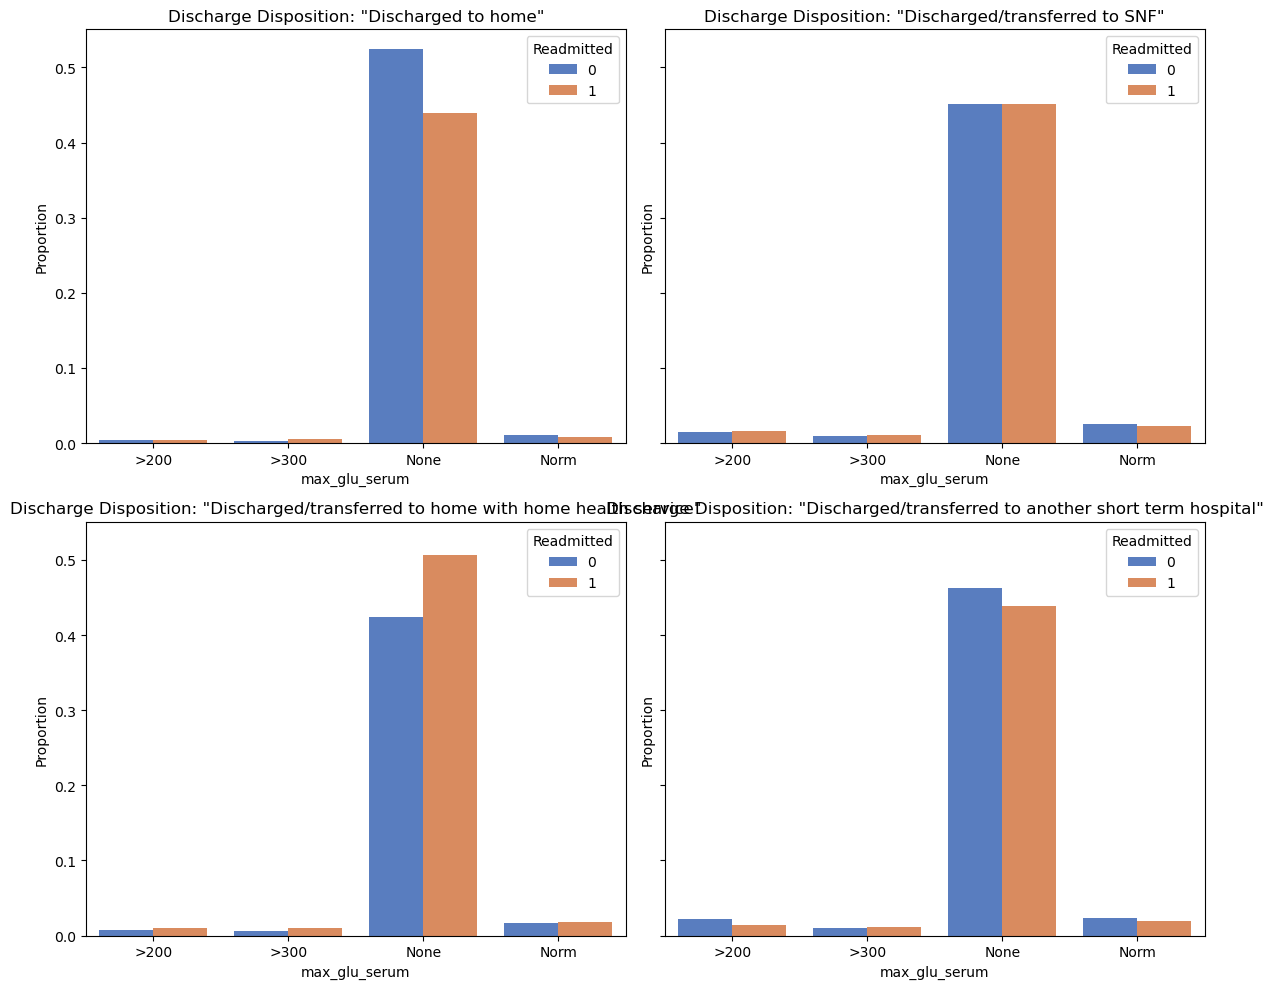

In [55]:
# Get the top 4 most represented discharge dispositions
top_discharge_dispositions = df['discharge_disposition'].value_counts().nlargest(4).index

# Set up subplots with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True)

# Loop through each discharge_disposition and create a bar plot in the corresponding subplot
for i, discharge_disposition in enumerate(top_discharge_dispositions):
    # Calculate the row and column indices
    row_idx, col_idx = divmod(i, 2)

    # Create a subset of the data for the current discharge_disposition
    subset_df = df[df['discharge_disposition'] == discharge_disposition]

    # Calculate proportions manually
    proportions = subset_df.groupby(['max_glu_serum', 'readmitted']).size() / len(subset_df)
    proportions = proportions.reset_index(name='proportion')

    # Create the bar plot with normalization
    sns.barplot(x='max_glu_serum', y='proportion', hue='readmitted', data=proportions, palette="muted", ax=axes[row_idx, col_idx])

    # Customize the plot
    axes[row_idx, col_idx].set_title(f'Discharge Disposition: "{discharge_disposition}"')
    axes[row_idx, col_idx].set_xlabel('max_glu_serum')
    axes[row_idx, col_idx].set_ylabel('Proportion')
    axes[row_idx, col_idx].legend(title="Readmitted", loc="upper right")

# Adjust layout
plt.tight_layout()
plt.show()

We can see how the discharge disposition impact the readmition proportion.

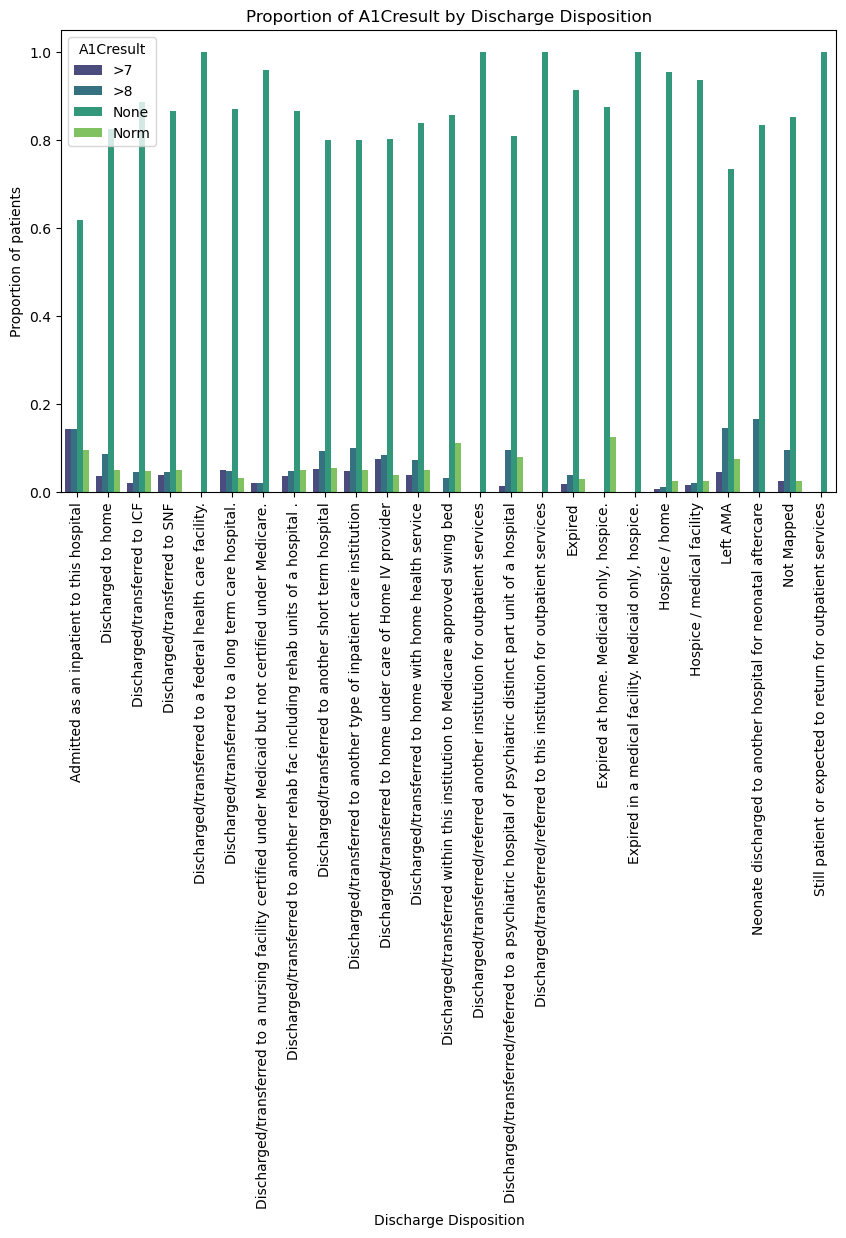

In [56]:
# Calculate counts and proportions within each 'discharge_disposition'
df_counts = df[['A1Cresult', 'discharge_disposition']].groupby(['discharge_disposition', 'A1Cresult']).size().reset_index(name='count')
df_counts['proportion'] = df_counts.groupby('discharge_disposition')['count'].transform(lambda x: x / x.sum())

# Plotting the count plot with proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='discharge_disposition', y='proportion', hue='A1Cresult', data=df_counts, palette='viridis')

# Adding labels and title
plt.xlabel('Discharge Disposition')
plt.ylabel('Proportion of patients')
plt.title('Proportion of A1Cresult by Discharge Disposition')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

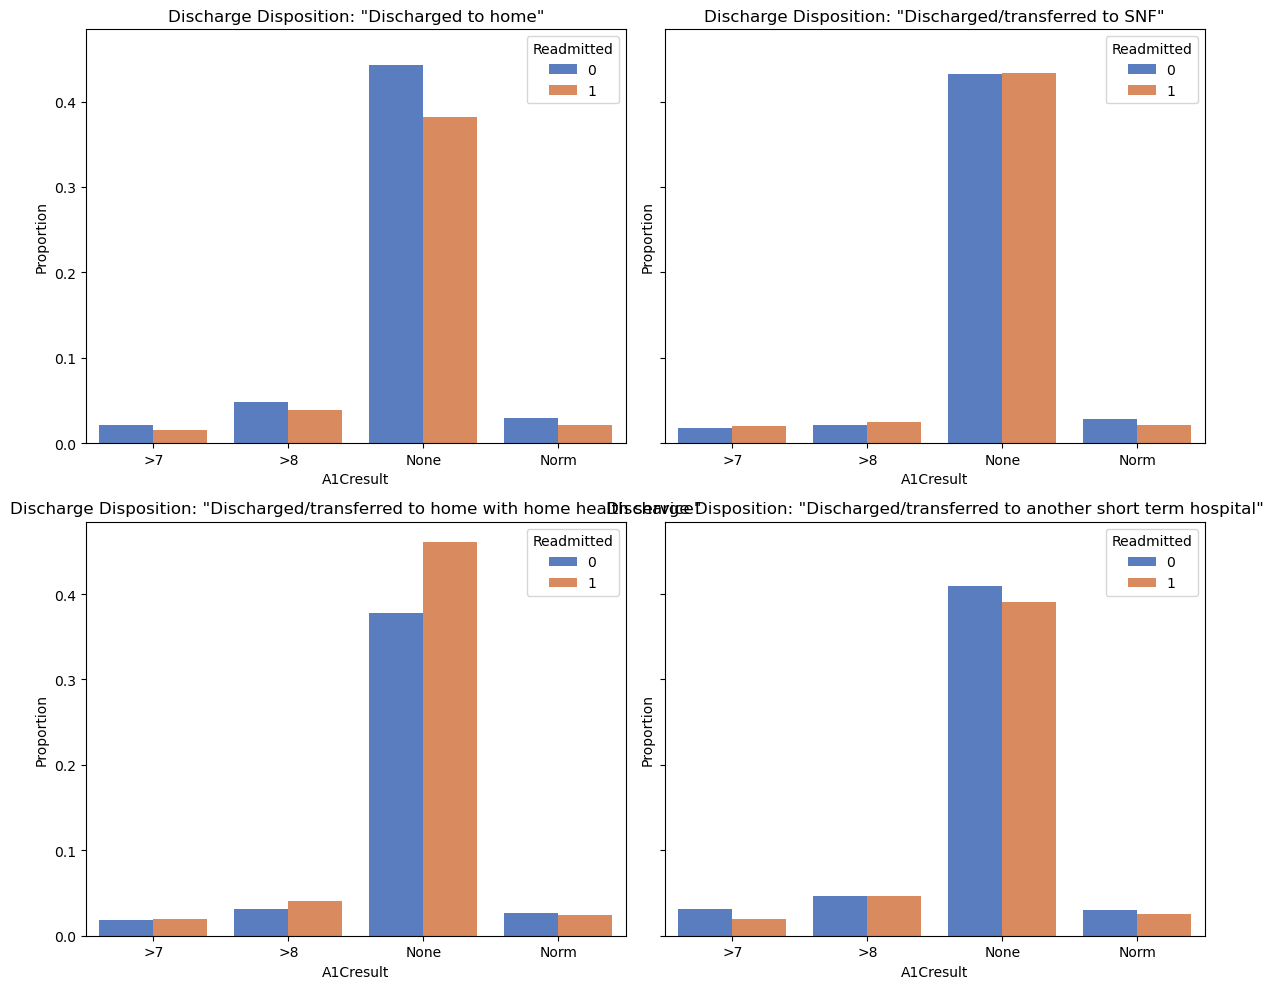

In [57]:
# Get the top 4 most represented discharge dispositions
top_discharge_dispositions = df['discharge_disposition'].value_counts().nlargest(4).index

# Set up subplots with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True)

# Loop through each discharge_disposition and create a bar plot in the corresponding subplot
for i, discharge_disposition in enumerate(top_discharge_dispositions):
    # Calculate the row and column indices
    row_idx, col_idx = divmod(i, 2)

    # Create a subset of the data for the current discharge_disposition
    subset_df = df[df['discharge_disposition'] == discharge_disposition]

    # Calculate proportions manually
    proportions = subset_df.groupby(['A1Cresult', 'readmitted']).size() / len(subset_df)
    proportions = proportions.reset_index(name='proportion')

    # Create the bar plot with normalization
    sns.barplot(x='A1Cresult', y='proportion', hue='readmitted', data=proportions, palette="muted", ax=axes[row_idx, col_idx])

    # Customize the plot
    axes[row_idx, col_idx].set_title(f'Discharge Disposition: "{discharge_disposition}"')
    axes[row_idx, col_idx].set_xlabel('A1Cresult')
    axes[row_idx, col_idx].set_ylabel('Proportion')
    axes[row_idx, col_idx].legend(title="Readmitted", loc="upper right")

# Adjust layout
plt.tight_layout()
plt.show()

### Diagnostics

Text(0.5, 1.0, 'number of patient per diagnostics 1')

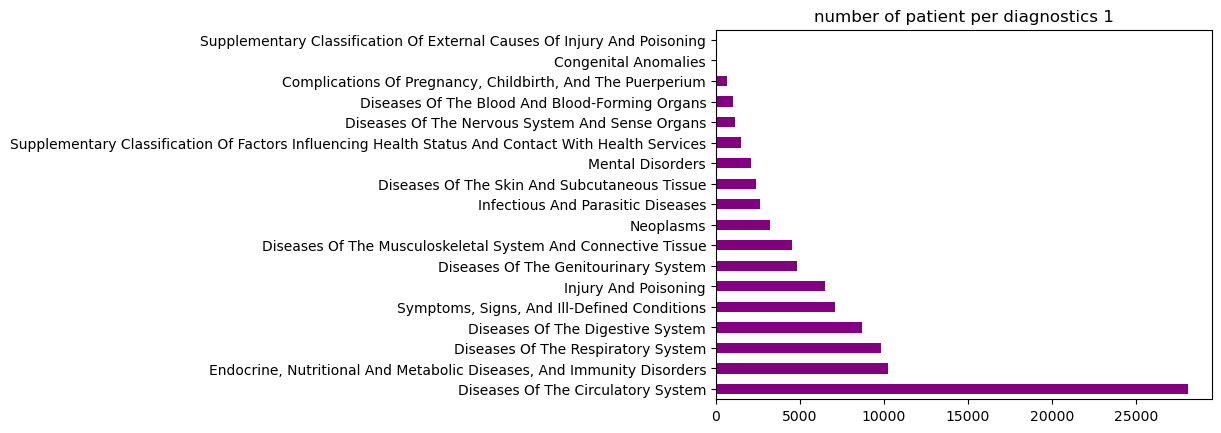

In [58]:
df_bar = df['diag_1'].value_counts()
df_bar.sort_values(ascending=False).plot.barh(color='purple')
plt.title('number of patient per diagnostics 1')

Text(0.5, 1.0, 'number of patient per diagnostics 2')

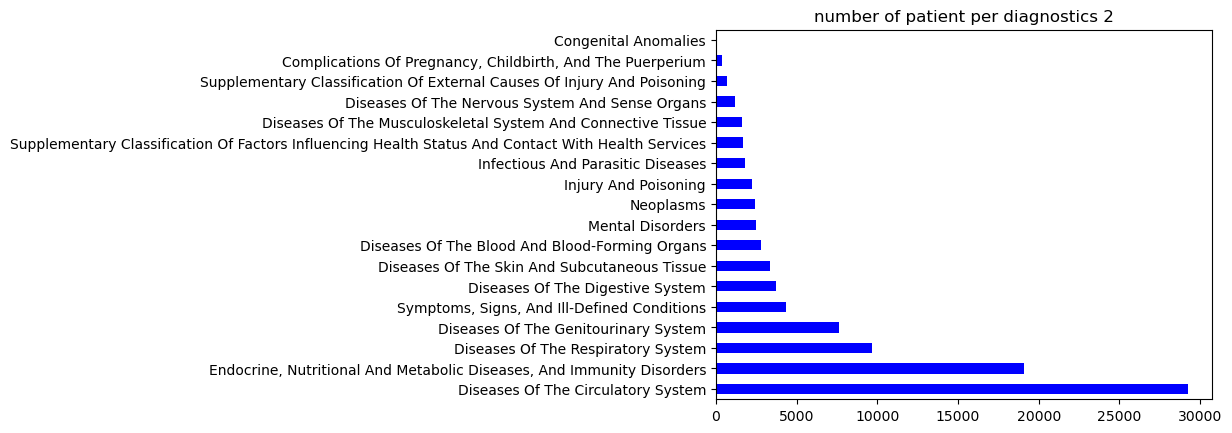

In [59]:
df_bar = df['diag_2'].value_counts()
df_bar.sort_values(ascending=False).plot.barh(color='blue')
plt.title('number of patient per diagnostics 2')

Text(0.5, 1.0, 'number of patient per diagnostics 3')

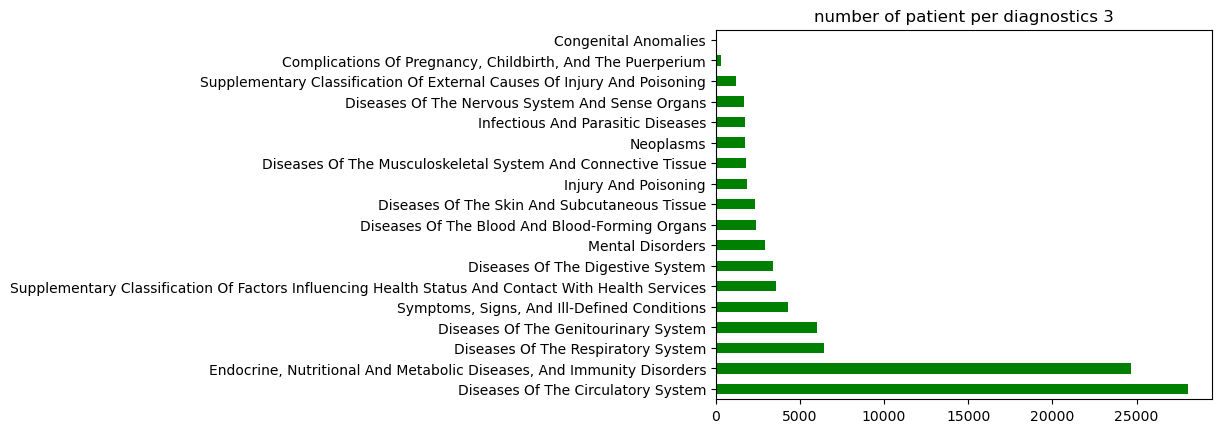

In [60]:
df_bar = df['diag_3'].value_counts()
df_bar.sort_values(ascending=False).plot.barh(color='green')
plt.title('number of patient per diagnostics 3')

Text(0.5, 1.0, 'number of patient per diagnostics 3')

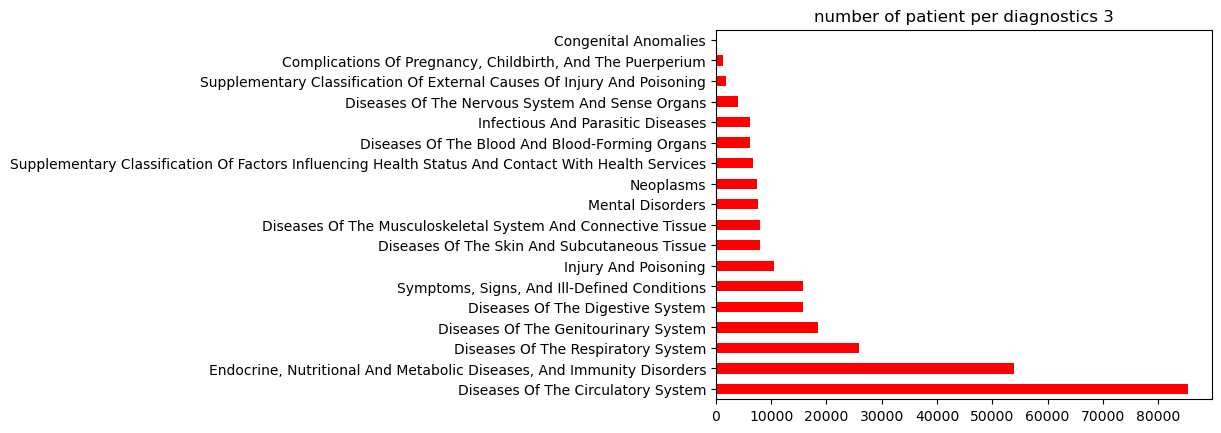

In [81]:
all_diags = pd.concat([df['diag_1'], df['diag_2'], df['diag_3']])
df_bar = all_diags.value_counts()
df_bar.sort_values(ascending=False).plot.barh(color='red')
plt.title('number of patient per diagnostics 3')

We can see that the proportion of each diagnostics values is different depending of the diag number. Consequently it may seems a good idea to keep them separated for the prediction.

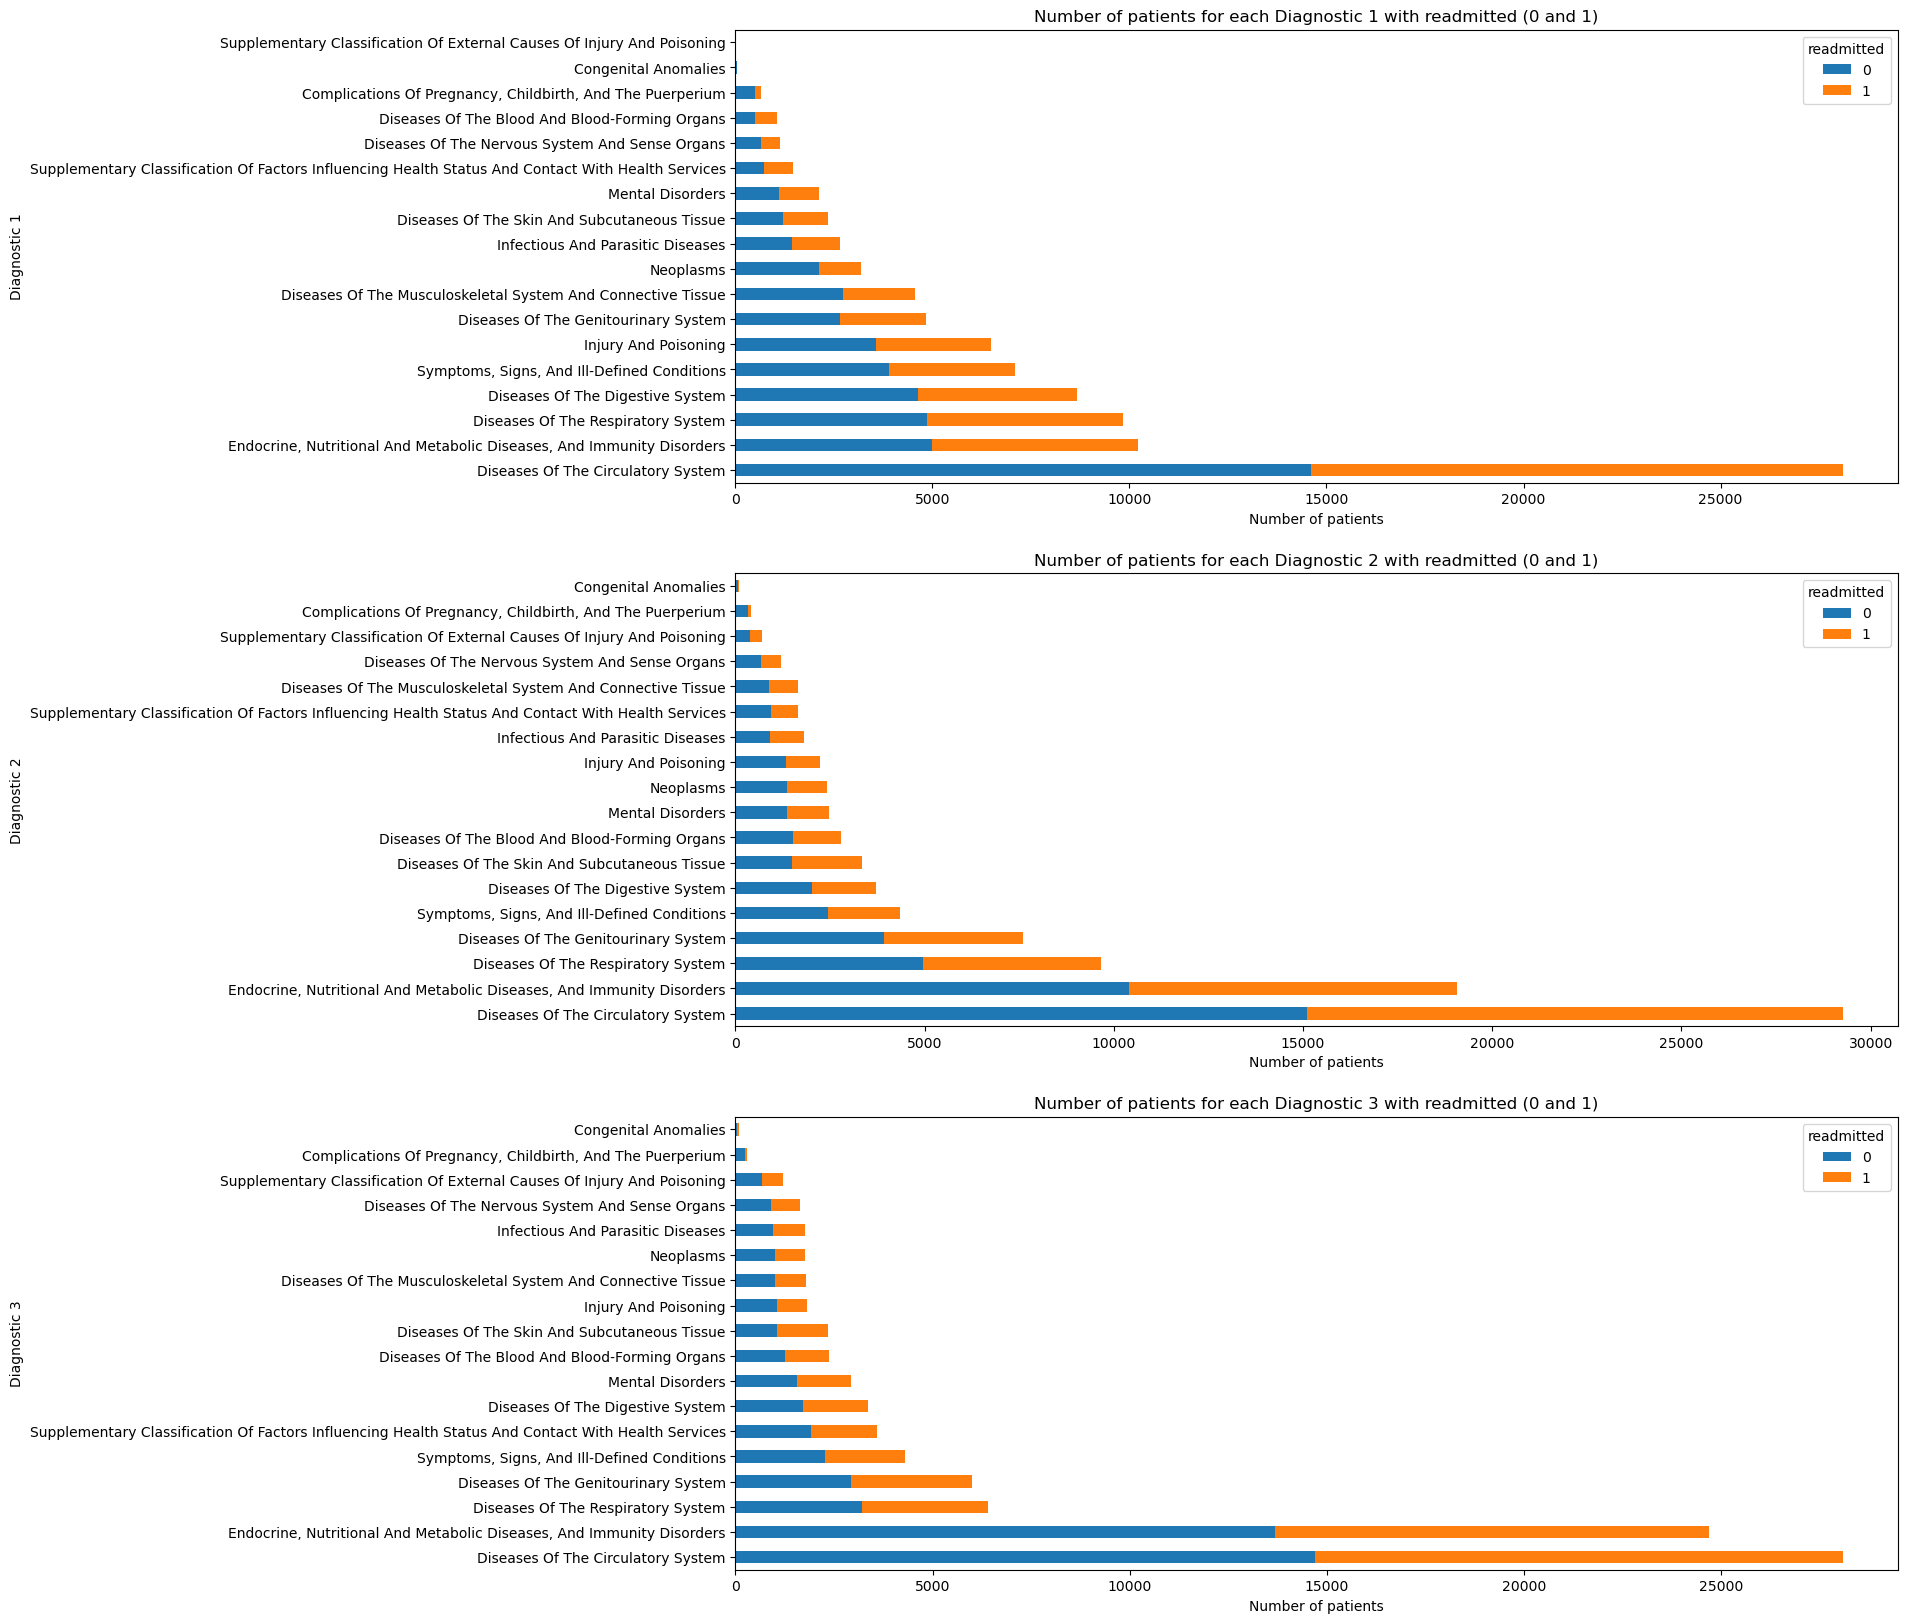

In [61]:
# Create a DataFrame with the necessary columns for diag_1
df_bar_diag_1 = df.groupby(['diag_1', 'readmitted']).size().unstack(fill_value=0)

# Sort the DataFrame by the sum of values for each diagnostic
df_bar_diag_1['total'] = df_bar_diag_1.sum(axis=1)
df_bar_diag_1 = df_bar_diag_1.sort_values(by='total', ascending=False).drop('total', axis=1)

# Plot the stacked horizontal bar chart for diag_1
plt.figure(figsize=(15, 20))
ax1 = plt.subplot(3,1, 1)  # 13 rows, 1 column, subplot 1
df_bar_diag_1.plot(kind='barh', stacked=True, ax=ax1)
plt.xlabel('Number of patients')
plt.ylabel('Diagnostic 1')
plt.title('Number of patients for each Diagnostic 1 with readmitted (0 and 1)')

# Create a DataFrame with the necessary columns for diag_2
df_bar_diag_2 = df.groupby(['diag_2', 'readmitted']).size().unstack(fill_value=0)

# Sort the DataFrame by the sum of values for each diagnostic
df_bar_diag_2['total'] = df_bar_diag_2.sum(axis=1)
df_bar_diag_2 = df_bar_diag_2.sort_values(by='total', ascending=False).drop('total', axis=1)


# Plot the stacked horizontal bar chart for diag_2
ax2 = plt.subplot(3,1, 2)  # 3 rows, 1 column, subplot 2
df_bar_diag_2.plot(kind='barh', stacked=True, ax=ax2)
plt.xlabel('Number of patients')
plt.ylabel('Diagnostic 2')
plt.title('Number of patients for each Diagnostic 2 with readmitted (0 and 1)')

# Create a DataFrame with the necessary columns for diag_3
df_bar_diag_3 = df.groupby(['diag_3', 'readmitted']).size().unstack(fill_value=0)

# Sort the DataFrame by the sum of values for each diagnostic
df_bar_diag_3['total'] = df_bar_diag_3.sum(axis=1)
df_bar_diag_3 = df_bar_diag_3.sort_values(by='total', ascending=False).drop('total', axis=1)

# Plot the stacked horizontal bar chart for diag_3
ax3 = plt.subplot(3,1, 3)  # 3 rows, 1 column, subplot 3
df_bar_diag_3.plot(kind='barh', stacked=True, ax=ax3)
plt.xlabel('Number of patients')
plt.ylabel('Diagnostic 3')
plt.title('Number of patients for each Diagnostic 3 with readmitted (0 and 1)')


# Show the plots
plt.show()

Still it does not seems to have an impact on the readmission.

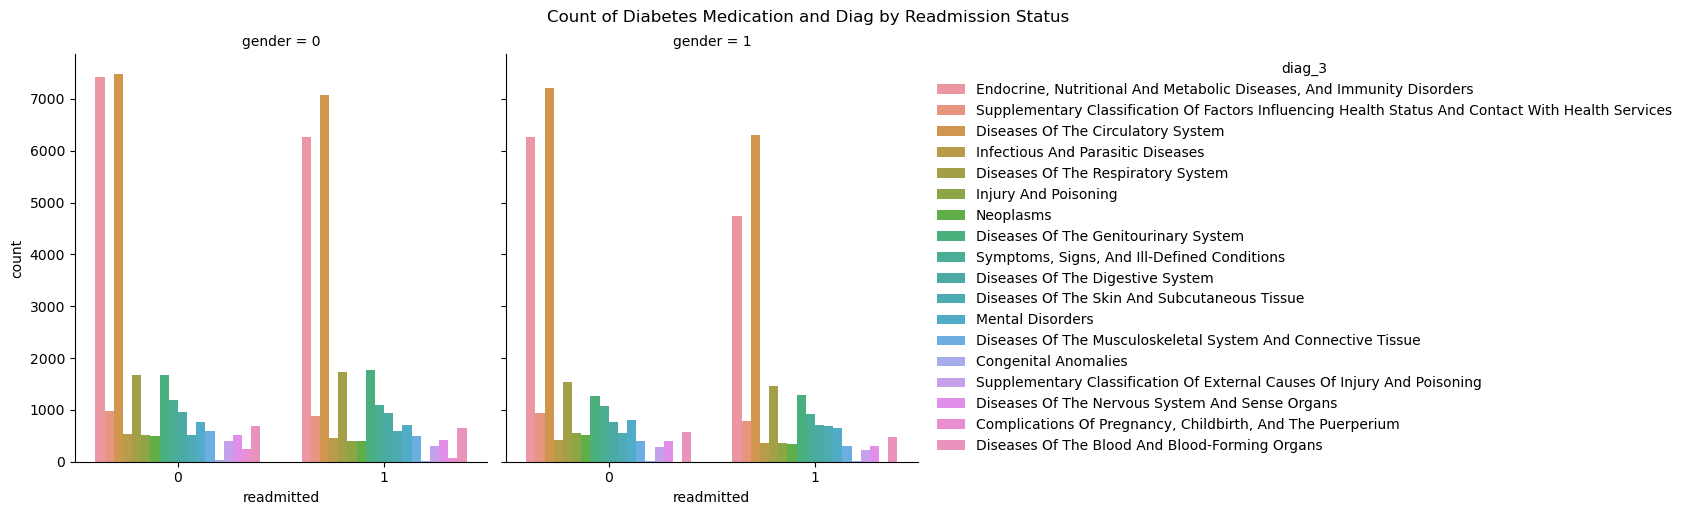

In [83]:
# Create a catplot
sns.catplot(x='readmitted', hue='diag_3', col='gender', kind='count', data=df)

# Set labels and title
plt.xlabel('readmitted')
plt.ylabel('Count')
plt.suptitle('Count of Diabetes Medication and Diag by Readmission Status', y=1.02)

# Show the plot
plt.show()

We can see here how the gender and diag_3 categories which both did not seems to have an impact on readmitted here are impacted in some categories.

## Link between our dataset and continuous values

Number of emergency, outpatient and inpatient are all incounters at the hospital. It does seems wise to treat them together in a same plot.

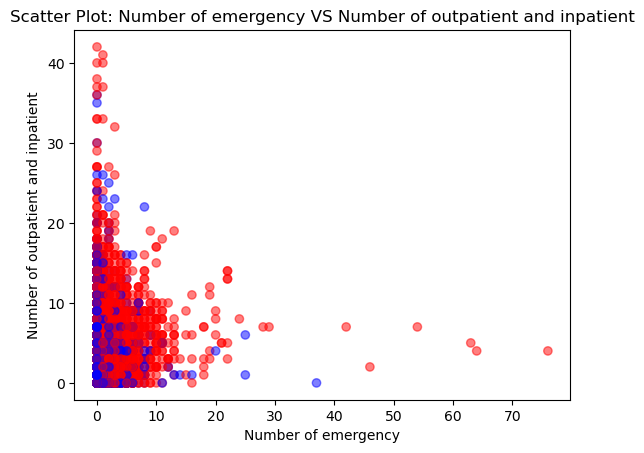

In [84]:
# Create a color map for readmitted (0: blue, 1: red)
colors = np.where(df['readmitted'] == 0, 'blue', 'red')

# Create the scatter plot
plt.scatter(df['number_emergency'], df['number_outpatient']+df['number_inpatient'], c=colors, alpha=0.5)
plt.title("Scatter Plot: Number of emergency VS Number of outpatient and inpatient")
plt.xlabel("Number of emergency")
plt.ylabel("Number of outpatient and inpatient")

# Show the plot
plt.show()

We can see on this graph that the number of incounters go with a higher chance of readmission.

In [ ]:
# Create a Bokeh data source
source = ColumnDataSource(df)

# Create a linear colormap to map 'readmitted' values to colors
mapper = linear_cmap(field_name='readmitted', palette=Viridis256, low=0, high=1)

# Create the Bokeh figure
p = figure(width=800, height=600, tools='pan,box_zoom,reset', title='Bokeh Graph')

# Add points to the graph using the specified columns
scatter = p.scatter(x='num_lab_procedures', y='num_medications', size='time_in_hospital',
                    color=mapper, source=source, legend_field='readmitted', alpha=0.6)

# Add axes and a legend
p.xaxis.axis_label = 'Number of Lab Procedures'
p.yaxis.axis_label = 'Number of Medications'
p.legend.title = 'Readmitted'

# Show the graph in the notebook
output_notebook()
show(p)

We can observe a correlation between the number of lab procedures and number of medication. A certain quantity of procedures (over 80) is associated with at least 10 medicines.
Now there is a lot of points with this graph but bokeh allow us to zoom in. We can than found certain paterns. For exemple if we zoom between 40 nd 70 edicines and between 40 and 80 lab procedures we will found that almost all the small points are purple and most of the big ones are yellow. Meaning in this category the number of time spend in the hospital seems to have an impact on the readmition.

Consequently we are looking more precisely to the number of medication. We are ploting the distribution of number of medication for readmitted and not readmitted patients. 

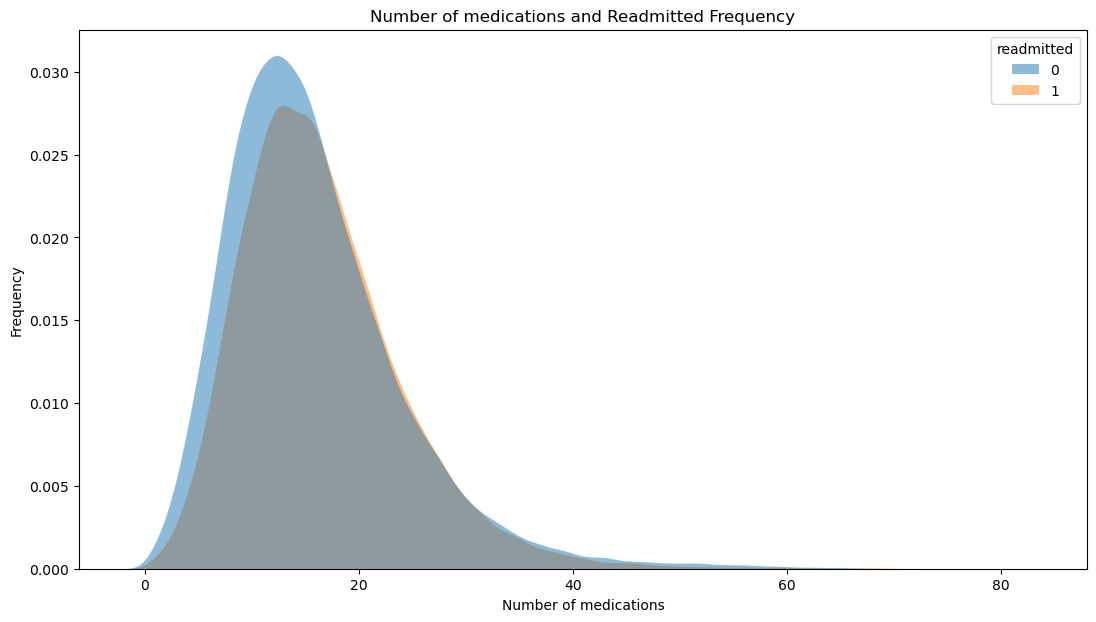

In [63]:
fig, ax = plt.subplots(figsize=(13, 7))

sns.kdeplot(data=df, x='num_medications', hue='readmitted', fill=True, alpha=.5, linewidth=0)

ax.set(xlabel='Number of medications', ylabel='Frequency')
plt.title('Number of medications and Readmitted Frequency')

plt.show()

We can see that the difference between the two distribution happens for less than 20 medicines taken

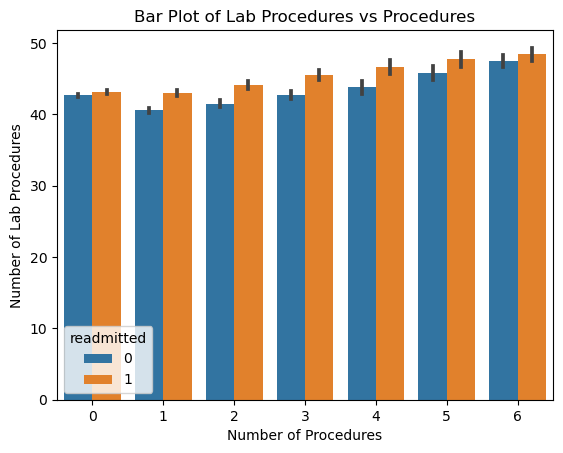

In [64]:
# Create a bar plot
sns.barplot(x='num_procedures', y='num_lab_procedures', hue='readmitted', data=df)

# Set labels and title
plt.xlabel('Number of Procedures')
plt.ylabel('Number of Lab Procedures')
plt.title('Bar Plot of Lab Procedures vs Procedures')

# Show the plot
plt.show()

The number of lab procedures increase with the number of procedures. The proportion of readmition does not change.

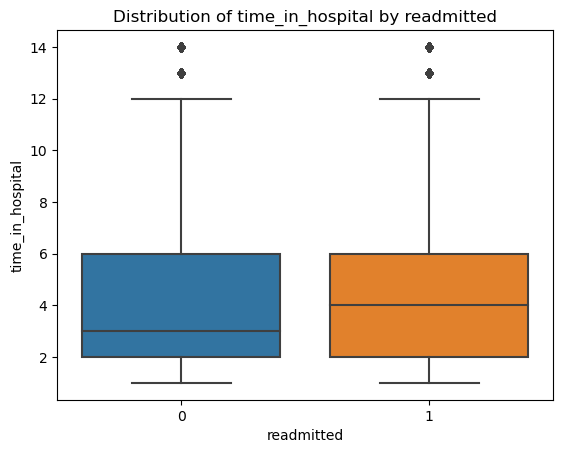

In [65]:
sns.boxplot(x='readmitted', y='time_in_hospital', data=df,order=sorted(df['readmitted'].unique()))
plt.title(f'Distribution of time_in_hospital by readmitted')
plt.show()

The time spent in the hospital is less for not readmitted patients.

### Same patient on differents columns

In [66]:
df['patient_nbr'].nunique()

66534

In [67]:
(df['patient_nbr'].value_counts()>1).sum()

15510

There are 16,280 patients who returned at least once out of over 68,629

In [68]:
resultat = df.groupby('patient_nbr').count().sort_index(ascending=False)
resultat = resultat[resultat['race'] > 1]
resultat.describe()

race        gender           age  time_in_hospital  \
count  15510.000000  15510.000000  15510.000000      15510.000000   
mean       2.798453      2.798453      2.798453          2.798453   
std        1.596670      1.596670      1.596670          1.596670   
min        2.000000      2.000000      2.000000          2.000000   
25%        2.000000      2.000000      2.000000          2.000000   
50%        2.000000      2.000000      2.000000          2.000000   
75%        3.000000      3.000000      3.000000          3.000000   
max       39.000000     39.000000     39.000000         39.000000   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count        15510.000000    15510.000000     15510.000000       15510.000000   
mean             2.798453        2.798453         2.798453           2.798453   
std              1.596670        1.596670         1.596670           1.596670   
min              2.000000        2.000000         2.000000           2.000000   
25%              2.000000        2.000000         2.000000           2.000000   
50%              2.000000        2.000000         2.000000           2.000000   
75%              3.000000        3.000000         3.000000           3.000000   
max             39.000000       39.000000        39.000000          39.000000   

       number_emergency  number_inpatient  ...  pioglitazone  rosiglitazone  \
count      15510.000000      15510.000000  ...  15510.000000   15510.000000   
mean           2.798453          2.798453  ...      2.798453       2.798453   
std            1.596670          1.596670  ...      1.596670       1.596670   
min            2.000000          2.000000  ...      2.000000       2.000000   
25%            2.000000          2.000000  ...      2.000000       2.000000   
50%            2.000000          2.000000  ...      2.000000       2.000000   
75%            3.000000          3.000000  ...      3.000000       3.000000   
max           39.000000         39.000000  ...     39.000000      39.000000   

            insulin        change   diabetesMed    readmitted  \
count  15510.000000  15510.000000  15510.000000  15510.000000   
mean       2.798453      2.798453      2.798453      2.798453   
std        1.596670      1.596670      1.596670      1.596670   
min        2.000000      2.000000      2.000000      2.000000   
25%        2.000000      2.000000      2.000000      2.000000   
50%        2.000000      2.000000      2.000000      2.000000   
75%        3.000000      3.000000      3.000000      3.000000   
max       39.000000     39.000000     39.000000     39.000000   

       rare_medicine_taken  admission_type  discharge_disposition  \
count         15510.000000    15510.000000           15510.000000   
mean              2.798453        2.798453               2.798453   
std               1.596670        1.596670               1.596670   
min               2.000000        2.000000               2.000000   
25%               2.000000        2.000000               2.000000   
50%               2.000000        2.000000               2.000000   
75%               3.000000        3.000000               3.000000   
max              39.000000       39.000000              39.000000   

       admission_source  
count      15510.000000  
mean           2.798453  
std            1.596670  
min            2.000000  
25%            2.000000  
50%            2.000000  
75%            3.000000  
max           39.000000  

[8 rows x 30 columns]

However, only a quarter return frequently, considering that the average is 2.8

# Prédiction

## Data splitting

In [70]:
Y = df1["readmitted"]#objectiv
X = df1.drop(labels = ["readmitted","patient_nbr"], axis = 1)#data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)#splitting

We are using target encoding after trying both this one is more efficient.

## Normalisation

In [71]:
colonnes_normalised=['age', 'time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient',
        'number_emergency', 'number_inpatient','number_diagnoses']
scaler = RobustScaler()
x_normal = scaler.fit_transform(x_train[colonnes_normalised])
x_train[colonnes_normalised]=x_normal

## importations,models and grids

We are choosing categorical model: Logistic regression, Gradient Boosting Classifier and Random Forest. The last two are supposed to be more efficient as they can detect non linear correlation between variables. In our data set there is not a lot of variable linear correlated to our target variable, consequently Gradient Boosting Classifier and Random Forest should provide us better results.

In [72]:
#modèles
models = {
    'Random Forest': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=10000)
}

#grides
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [ 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}


#lien entre modèle et sa grille
grids ={
    'Random Forest' : param_grid_rf,
    'GradientBoostingClassifier' : param_grid_gb,
    'LogisticRegression':param_grid_lr

}

In [84]:
def pred_grid(model_name):
   #fitting with best parameters
  random_search = GridSearchCV(models[model_name], param_grid=grids[model_name], scoring='accuracy', cv=5)
  random_search.fit(x_train, y_train)
  best_params = random_search.best_params_
  best_model = random_search.best_estimator_

  #prediction
  y_pred = best_model.predict(x_test)

  #one kind of error
  mse = mean_squared_error(y_test, y_pred)
  conf_matrix=confusion_matrix(y_test,y_pred)

  print(f"--- {model_name} ---")
  print(f"Best Model Mean Squared Error: {mse}\n")
  print("Meilleurs hyperparamètres:", random_search.best_params_)
  print("Accuracy: ",accuracy_score(y_test, y_pred),"\n")
  print("Matrice de confusion:", conf_matrix)
  print("Meilleur score de performance:", random_search.best_score_)
  print(classification_report(y_test,y_pred))

def pred(model_name):
  #fitting with best parameters
  models[model_name].fit(x_train, y_train)

  #prediction
  y_pred = models[model_name].predict(x_test)

  #one kind of error
  mse = mean_squared_error(y_test, y_pred)
  conf_matrix=confusion_matrix(y_test,y_pred)

  print(f"--- {model_name} ---")
  print(f"Best Model Mean Squared Error: {mse}\n")
  print("Accuracy: ",accuracy_score(y_test, y_pred),"\n")
  print("Matrice de confusion:\n", conf_matrix)
  print(classification_report(y_test,y_pred))
def test_hyperparameters(algo,parameters,standardized_X,Y_train):
    grid=GridSearchCV(estimator=models[algo],param_grid=parameters,error_score='raise')
    grid.fit(standardized_X,Y_train)
    print(grid.best_score_,grid.best_estimator_)
    return grid.best_score_,grid.best_estimator_

In [74]:
pred("LogisticRegression")

--- LogisticRegression ---
Best Model Mean Squared Error: 0.5115429418616965

Accuracy:  0.4884570581383035 

Matrice de confusion:
 [[ 472 9552]
 [ 109 8753]]
              precision    recall  f1-score   support

           0       0.81      0.05      0.09     10024
           1       0.48      0.99      0.64      8862

    accuracy                           0.49     18886
   macro avg       0.65      0.52      0.37     18886
weighted avg       0.66      0.49      0.35     18886



In [75]:
pred("Random Forest")

--- Random Forest ---
Best Model Mean Squared Error: 0.22148681563062586

Accuracy:  0.7785131843693741 

Matrice de confusion:
 [[8850 1174]
 [3009 5853]]
              precision    recall  f1-score   support

           0       0.75      0.88      0.81     10024
           1       0.83      0.66      0.74      8862

    accuracy                           0.78     18886
   macro avg       0.79      0.77      0.77     18886
weighted avg       0.79      0.78      0.78     18886



In [76]:
pred("GradientBoostingClassifier")

--- GradientBoostingClassifier ---
Best Model Mean Squared Error: 0.22630519961876522

Accuracy:  0.7736948003812347 

Matrice de confusion:
 [[8163 1861]
 [2413 6449]]
              precision    recall  f1-score   support

           0       0.77      0.81      0.79     10024
           1       0.78      0.73      0.75      8862

    accuracy                           0.77     18886
   macro avg       0.77      0.77      0.77     18886
weighted avg       0.77      0.77      0.77     18886



In [77]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=None, min_samples_split=2),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3),
    'LogisticRegression': LogisticRegression(random_state=42,max_iter=10000)
}

pred("LogisticRegression")
pred("Random Forest")
pred("GradientBoostingClassifier")

--- LogisticRegression ---
Best Model Mean Squared Error: 0.5115429418616965

Accuracy:  0.4884570581383035 

Matrice de confusion:
 [[ 472 9552]
 [ 109 8753]]
              precision    recall  f1-score   support

           0       0.81      0.05      0.09     10024
           1       0.48      0.99      0.64      8862

    accuracy                           0.49     18886
   macro avg       0.65      0.52      0.37     18886
weighted avg       0.66      0.49      0.35     18886

--- Random Forest ---
Best Model Mean Squared Error: 0.22175156200360055

Accuracy:  0.7782484379963994 

Matrice de confusion:
 [[8647 1377]
 [2811 6051]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.81     10024
           1       0.81      0.68      0.74      8862

    accuracy                           0.78     18886
   macro avg       0.78      0.77      0.77     18886
weighted avg       0.78      0.78      0.78     18886

--- GradientBoostingClassifier

We used grid like this to found the best results for each model:

In [88]:
param_grid = {'C': [0.01,  0.1, 1], 'penalty': ['l2']}
test_hyperparameters("LogisticRegression",param_grid,x_train, y_train)

0.7518333934296841 LogisticRegression(C=0.01, max_iter=10000, random_state=42)


(0.7518333934296841,
 LogisticRegression(C=0.01, max_iter=10000, random_state=42))